# **Veri seti hakkında:**

- Veri Kaynağı: Edmunds
- Veri Formatı: CSV
- Boyut: 27.000+ yorum / 137 MB
- Kapsam: Yalnızca Ford marka araçlar
- URL: https://www.kaggle.com/datasets/ankkur13/edmundsconsumer-car-ratings-and-reviews

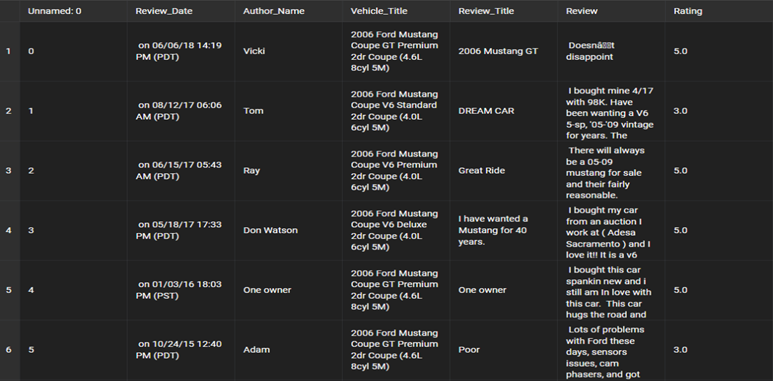

# **Zipf Yasası Analizi**

**Zipf Yasası – Adımlar:**

1. Review sütunundaki tüm yorumları birleştir.

2. Küçük harfe çevir, noktalama işaretlerini temizle.

3. Kelimelere ayır (tokenization).

4. Kelime frekanslarını hesapla.

5. Sıralayıp log-log grafiğini çiz.

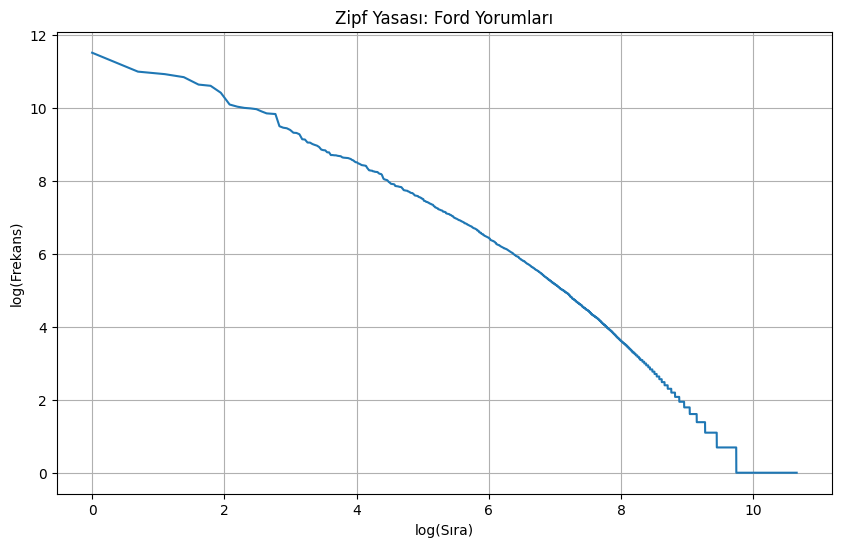

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter

# Veriyi oku (gerekirse senin yüklediğin yoldan al)
df = pd.read_csv("ford.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# 1. Yorumları birleştir
all_text = " ".join(str(x) for x in df["Review"].dropna())

# 2. Küçük harfe çevir ve noktalama temizliği
all_text = all_text.lower()
all_text = re.sub(r'[^\w\s]', '', all_text)  # noktalama işaretlerini sil

# 3. Tokenize (kelimelere ayır)
tokens = all_text.split()

# 4. Kelime frekanslarını hesapla
word_counts = Counter(tokens)
most_common = word_counts.most_common()

# 5. Sıralı frekansları al
ranks = range(1, len(most_common)+1)
frequencies = [freq for word, freq in most_common]

# 6. Log-log grafiği çiz
plt.figure(figsize=(10, 6))
plt.plot(np.log(ranks), np.log(frequencies))
plt.title("Zipf Yasası: Ford Yorumları")
plt.xlabel("log(Sıra)")
plt.ylabel("log(Frekans)")
plt.grid(True)
plt.show()


**Grafikte Zipf yasasına uygun bir eğri elde ettik (yani log-log ekseninde aşağı eğimli doğrusal bir yapı var)
 bu da bizlere yorum verilerinin yeterli ve doğru olduğunu gösteriyor.**

# **Ön İşleme (Pre-processing) Aşamaları**
1. **Stop Word Removal:**

Bu adımda, anlam taşımayan ya da çok sık geçen kelimeler (örn. "the", "is", "and", "but") yorumlardan çıkarılır. Review_NoStop adlı yeni bir sütun oluştu. Bu sütun stop words çıkarılmış hali içermektedir.

Kullanılan araçlar ve kütüphaneler:

pandas: Veri setini okuma ve DataFrame işlemleri için kullanıldı.

re: Regular expressions (düzenli ifadeler) yardımıyla noktalama ve özel karakterleri temizlemek için kullanıldı.

nltk: Doğal dil işleme için kullanıldı. Özellikle:
stopwords (sık geçen kelime listesi)
word_tokenize (kelimeye ayırmak için)

Kullanılan NLTK Alt Modülleri:

nltk.download('punkt'): Tokenizer için.

nltk.download('stopwords'): İngilizce sık kullanılan kelimeler listesini indirmek için.

Kodun İşlevi ve Açıklaması:

Kod, Review sütunundaki her bir yorum için şu işlemleri uygular:

Küçük harfe çevirme
Örn: "I LOVE this car" → "i love this car"

Noktalama işaretlerini temizleme
Örn: "love this car!" → "love this car"

Kelimelere ayırma (Tokenization)
Örn: "love this car" → ['love', 'this', 'car']

Stopword çıkarımı
NLTK'nın İngilizce listesi kullanılarak:
Örn: ['love', 'this', 'car'] → ['love', 'car']
(this kelimesi çıkarılır çünkü sık kullanılan anlamsız kelimedir)

Sonuç tekrar string'e çevrilir ve Review_NoStop adlı yeni bir sütuna yazılır.

Review_NoStop sütunu, bir sonraki adım olan tokenization, lemmatization ve vektörleştirme (TF-IDF / Word2Vec) işlemleri için hazır hâle getirilmiş yorumları içerir.

Bu sayede model sadece anlamlı ve bilgi taşıyan kelimeleri kullanır, eğitim kalitesi artar.


In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Gerekli NLTK dosyalarını indir
nltk.download('punkt')
nltk.download('stopwords')

# Veriyi oku
df = pd.read_csv("ford.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Stop words listesi (İngilizce)
stop_words = set(stopwords.words('english'))

# Stop word removal fonksiyonu
def remove_stopwords(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

# Yeni sütunu ekle
df["Review_NoStop"] = df["Review"].apply(remove_stopwords)

# Dosyayı aynı isimle üzerine yaz
df.to_csv("ford.csv", index=False)

# İlk 5 satırı göster (kontrol)
df[["Review", "Review_NoStop"]].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review,Review_NoStop
0,Doesnât disappoint,doesnât disappoint
1,I bought mine 4/17 with 98K. Have been wantin...,bought mine 417 98k wanting v6 5sp 0509 vintag...
2,There will always be a 05-09 mustang for sale...,always 0509 mustang sale fairly reasonable pur...
3,I bought my car from an auction I work at ( A...,bought car auction work adesa sacramento love ...
4,I bought this car spankin new and i still am ...,bought car spankin new still love car car hugs...


# **Ön İşleme (Pre-processing) Aşamaları**

2. **Tokenization:**

Bu adımda metinler tek tek kelimelere ayrılır (token) ve bu işlem sırasında noktalama işaretleri de temizlenir.

Bu işlemin sonucunda her yorum bir listeye dönüşmüştür: ["i", "bought", "this", "car", "new", "and", "still", "love", "it"]

Bu liste, lemmatization ve stemming adımları için temel veri olacak.

Kullanılan Araçlar ve Kütüphaneler:

pandas: CSV dosyasını okuyup yazmak ve sütunları düzenlemek için kullanılmıştır.

re: Noktalama işaretlerini temizlemek için kullanılan regular expression modülüdür. Python'un standart kütüphanesidir.

Kodun İşlevi – Açıklamalı Adımlar:

Kod, Review_NoStop sütunundaki her yorumu işleyerek şu adımları uygular:

Küçük harfe çevirme
Örn: "FAST car" → "fast car"

Noktalama temizliği
Örn: "fast, car!" → "fast car"

Boşluklara göre kelimelere ayırma (tokenization)
Örn: "fast car" → ["fast", "car"]

Sonuç, Tokens adlı yeni sütun olarak DataFrame’e eklenir.

Not:
Tokenization işlemi basit split() fonksiyonu ile yapılmıştır. Bu, hızlı ve temel bir yöntemdir.
Daha gelişmiş tokenization için nltk.word_tokenize() veya spacy gibi kütüphaneler kullanılabilir, ancak bu örnekte gereksiz karmaşıklık olmadan işlem yapılmıştır.

Amaç ve Kullanım:

Bu işlemle her yorum artık bir kelime listesi haline gelir.
Bu listeler, lemmatization, stemming, TF-IDF, Word2Vec gibi sonraki adımlar için doğrudan kullanılabilir hale getirilmiştir.
Ayrıca, Zipf Yasası gibi kelime sıklığı analizleri için de ham madde görevini görür.

In [ ]:
import pandas as pd
import re

# Veriyi oku
df = pd.read_csv("ford.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Tokenization fonksiyonu
def tokenize(text):
    if pd.isnull(text):
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Noktalama temizliği
    tokens = text.split()
    return tokens

# Token sütununu oluştur
df["Tokens"] = df["Review_NoStop"].apply(tokenize)

# Dosyayı tekrar kaydet (üzerine yaz)
df.to_csv("ford.csv", index=False)

# Örnek kontrol
df[["Review_NoStop", "Tokens"]].head()


,Review_NoStop,Tokens
0,doesnÃ¢t disappoint,"[doesnãt, disappoint]"
1,bought mine 417 98k wanting v6 5sp 0509 vintag...,"[bought, mine, 417, 98k, wanting, v6, 5sp, 050..."
2,always 0509 mustang sale fairly reasonable pur...,"[always, 0509, mustang, sale, fairly, reasonab..."
3,bought car auction work adesa sacramento love ...,"[bought, car, auction, work, adesa, sacramento..."
4,bought car spankin new still love car car hugs...,"[bought, car, spankin, new, still, love, car, ..."


# **Ön İşleme (Pre-processing) Aşamaları**

3. **Lowercasing:**

"Tokens" sütununu oluştururken lower() işlemini zaten uyguladım. Ama ödevde her adımın ayrıca ve açık şekilde gösterilmesi istendiği için lowercasing adımını da ayrı bir sütunla (Tokens_Lower) kaydettim. Bu adımı gerçekleştirirken "ast.literal_eval" kullandım. Çünkü:
CSV’ye liste olarak yazılması gereken
 sütunlar (['i', 'love', 'this', 'car']) bazen string olarak okunmaktadır. "ast.literal_eval()" onları tekrar liste haline çevirir.

 Kullanılan Araçlar ve Kütüphaneler:

 ast(abstract syntax trees): CSV okunduğunda "['This', 'Car']" gibi string haline gelen liste verilerini tekrar gerçek Python listesine çevirmek için kullanılmıştır. Bu sayede her kelimeye ayrı ayrı erişim mümkün olur.

 Kodun İşlevi – Açıklamalı Adımlar:

Kodun amacı, Tokens sütunundaki her kelime listesindeki kelimeleri küçük harfe çevirmektir:
Tokens sütunu "['This', 'Car']" gibi stringleşmiş liste olarak okunabilir.
Bu durumda ast.literal_eval() ile tekrar liste formatına çevrilir.
Her kelime .lower() ile küçük harfe dönüştürülür.
Sonuç olarak Tokens_Lower adında yeni bir sütun oluşturulur ve tüm kelimeler küçük harfli olur.Güncellenen DataFrame ford.csv dosyasına kalıcı olarak kaydedilir.

Bu Adımın Önemi:
Doğal dil işleme algoritmaları (TF-IDF, Word2Vec, LDA vb.) büyük/küçük harf ayrımı yapmaz.
"Car" ve "car" ayrı kelime olarak işlenmemelidir. Bu yüzden tüm kelimelerin küçük harfe çevrilmesi gerekir.
Bu adım, veri standardizasyonu için çok kritik bir adımdır.

In [ ]:
import pandas as pd

# Veriyi oku
df = pd.read_csv("ford.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# 'Tokens' sütunundaki her kelimeyi küçük harfe çevir
def lowercase_tokens(token_list):
    if isinstance(token_list, str):
        # Liste string olarak gelmiş olabilir → dönüştür
        import ast
        token_list = ast.literal_eval(token_list)
    return [token.lower() for token in token_list]

# Yeni sütunu oluştur
df["Tokens_Lower"] = df["Tokens"].apply(lowercase_tokens)

# Güncel dosyaya yaz
df.to_csv("ford.csv", index=False)

# Kontrol
df[["Tokens", "Tokens_Lower"]].head()


,Tokens,Tokens_Lower
0,"['doesnÃ£t', 'disappoint']","[doesnã£t, disappoint]"
1,"['bought', 'mine', '417', '98k', 'wanting', 'v...","[bought, mine, 417, 98k, wanting, v6, 5sp, 050..."
2,"['always', '0509', 'mustang', 'sale', 'fairly'...","[always, 0509, mustang, sale, fairly, reasonab..."
3,"['bought', 'car', 'auction', 'work', 'adesa', ...","[bought, car, auction, work, adesa, sacramento..."
4,"['bought', 'car', 'spankin', 'new', 'still', '...","[bought, car, spankin, new, still, love, car, ..."


# **Ön İşleme (Pre-processing) Aşamaları**

4. **Lemmatization:**

Bu adımda her kelime, kök (sözlükteki) hâline dönüştürülür.
Örneğin: "cars" → "car", "running" → "run" gibi.

Kullanılan Araçlar ve Kütüphaneler:

nltk.stem.WordNetLemmatizer: İngilizce kelimeleri kök (sözlükteki gerçek) hâline indirmek için kullanılır. Daha doğru ve dilbilgisel açıdan anlamlı dönüşüm sağlar.

nltk.download('wordnet'), nltk.download('omw-1.4'): Lemmatizer'ın doğru çalışması için gerekli olan sözlük verilerini indirir.

ast.literal_eval: CSV’den okunan string formatındaki liste verisini tekrar Python listesi hâline dönüştürmek için kullanılır.

Kodun İşlevi – Açıklamalı Adımlar:

Veri Okuma:
ford.csv dosyasından veri okunur.
Liste Formatı Kontrolü:
Tokens_Lower sütunu CSV’den string olarak gelmişse ast.literal_eval() ile gerçek listeye çevrilir.
Lemmatization:
Her kelime için lemmatizer.lemmatize(token) uygulanarak kök hâline getirilir.
Örn: "cars" → "car", "driving" → "driving" (bazı fiillerin hâli değişmeyebilir çünkü context bilinmiyor)
Yeni Sütun:
Sonuç, Tokens_Lemmatized adlı yeni bir sütuna yazılır.
Dosya Kaydı:
Güncellenmiş DataFrame, ford.csv dosyasına tekrar yazılır.

Bu Adımın Önemi:
Modelin daha anlamlı kelime temsilleri öğrenmesini sağlar.
Aynı anlamı taşıyan farklı kelime biçimlerinin (cars, car, driving, drive) tekilleştirilmesini sağlar.
TF-IDF ve Word2Vec gibi modellerde tekrar eden anlamlı kelimeler daha etkili yakalanır.


In [ ]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
import nltk
import ast

# Gerekli nltk bileşenlerini indir
nltk.download('wordnet')
nltk.download('omw-1.4')

# Veriyi oku
df = pd.read_csv("ford.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Lemmatizer nesnesi
lemmatizer = WordNetLemmatizer()

# Lemmatization fonksiyonu
def lemmatize_tokens(tokens):
    if isinstance(tokens, str):
        tokens = ast.literal_eval(tokens)
    return [lemmatizer.lemmatize(token) for token in tokens]

# Yeni sütunu oluştur
df["Tokens_Lemmatized"] = df["Tokens_Lower"].apply(lemmatize_tokens)

# Dosyayı kaydet
df.to_csv("ford.csv", index=False)

# Kontrol için göster
df[["Tokens_Lower", "Tokens_Lemmatized"]].head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Tokens_Lower,Tokens_Lemmatized
0,"['doesnÃÂÃÂ£ÃÂÃÂ£t', 'disappoint']","[doesnÃÂÃÂ£ÃÂÃÂ£t, disappoint]"
1,"['bought', 'mine', '417', '98k', 'wanting', 'v...","[bought, mine, 417, 98k, wanting, v6, 5sp, 050..."
2,"['always', '0509', 'mustang', 'sale', 'fairly'...","[always, 0509, mustang, sale, fairly, reasonab..."
3,"['bought', 'car', 'auction', 'work', 'adesa', ...","[bought, car, auction, work, adesa, sacramento..."
4,"['bought', 'car', 'spankin', 'new', 'still', '...","[bought, car, spankin, new, still, love, car, ..."


# **Ön İşleme (Pre-processing) Aşamaları**

5. **Stemming:**

Bu adımda kelimeler, daha kaba bir şekilde köklerine indirgenmiştir.
Örneğin: "driving" → "driv", "better" → "better".

Kullanılan Araçlar ve Kütüphaneler:

nltk.stem.PorterStemmer: İngilizce kelimeleri hızlı ve kurallı bir biçimde köklerine indirmek için kullanılır. Çok yaygın ve basit bir stemming algoritmasıdır.

ast.literal_eval: CSV’den okunan liste formatındaki veriler ("['car', 'fast']") aslında string’dir. Bu string ifadeyi tekrar gerçek Python listesine çevirmek için kullanılır.

Kodun İşlevi – Açıklamalı Adımlar:
CSV’den veri okunur.
Tokens_Lower sütunundaki her satır, önce ast.literal_eval() ile liste haline getirilir (eğer string ise).
Stemming işlemi yapılır:
Her kelime için stemmer.stem(token) uygulanır. Bu işlem, kelimenin son eklerini keserek kısa bir köke dönüştürür.
Sonuç, Tokens_Stemmed adlı yeni bir sütuna yazılır.
Güncellenmiş DataFrame, aynı isimle (ford.csv) kaydedilir.

Bu Adımın Önemi:
NLP'de bazı durumlarda lemmatization fazla yavaş olabilir, stemming ise hızlı ve genellikle yeterlidir.
Özellikle büyük veri kümelerinde daha düşük işlem maliyeti sağlar.
Ancak anlamsal doğruluk kaybı riski olduğu için dikkatli kullanılması gerekir.

Lemmatization daha anlamlı sonuçlar vermişken, stemming daha mekanik ve hızlıdır.

In [ ]:
import pandas as pd
from nltk.stem import PorterStemmer
import ast

# Veriyi oku
df = pd.read_csv("ford.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Stemmer nesnesi
stemmer = PorterStemmer()

# Stemming fonksiyonu
def stem_tokens(tokens):
    if isinstance(tokens, str):
        tokens = ast.literal_eval(tokens)
    return [stemmer.stem(token) for token in tokens]

# Yeni sütun oluştur
df["Tokens_Stemmed"] = df["Tokens_Lower"].apply(stem_tokens)

# Dosyayı kaydet
df.to_csv("ford.csv", index=False)

# Kontrol için göster
df[["Tokens_Lower", "Tokens_Stemmed"]].head()


,Tokens_Lower,Tokens_Stemmed
0,"['doesnÃÂÃÂÃÂÃÂ£ÃÂÃÂÃÂÃÂ£t', 'di...","[doesnãâãâãâãâ£ãâãâãâãâ£t, disap..."
1,"['bought', 'mine', '417', '98k', 'wanting', 'v...","[bought, mine, 417, 98k, want, v6, 5sp, 0509, ..."
2,"['always', '0509', 'mustang', 'sale', 'fairly'...","[alway, 0509, mustang, sale, fairli, reason, p..."
3,"['bought', 'car', 'auction', 'work', 'adesa', ...","[bought, car, auction, work, adesa, sacramento..."
4,"['bought', 'car', 'spankin', 'new', 'still', '...","[bought, car, spankin, new, still, love, car, ..."


# **Temizlenmiş Veri Seti Çıktıları**

"fordlemmatized.csv" veri setinde Zipf Grafiğinin çizimi:

Gözlemler:

Grafik, log(sıra) ile log(frekans) arasında yaklaşık doğrusal bir ilişki gösteriyor.
En sık geçen birkaç kelime çok yüksek frekansta, geri kalan kelimeler hızla düşen sıklığa sahip.
Eğrinin sonlarında ani düşüşler var, bu da nadir kelimelerin çok fazla olduğunu gösteriyor.

Yorum:

Lemmatization uygulandığı için benzer anlam taşıyan kelimeler tek kökte birleşmiş:
Örn. "cars", "car" → "car"
Bu, veri tekrarını azaltmış ve daha dengeli bir dağılım oluşturmuş.
Zipf yasasına uygunluk çok yüksek; bu, metnin doğal dil verisi olduğunu ve dilin yapısal özelliklerini taşıdığını gösterir.

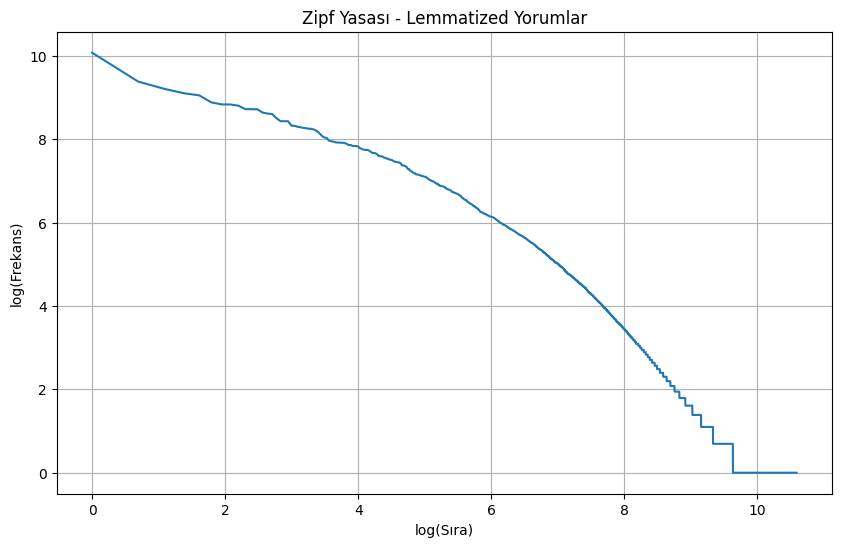

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import ast

# Veriyi oku
df = pd.read_csv("fordlemmatized.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# String olarak okunmuş listeyi gerçek listeye dönüştür
all_tokens = []

for row in df["Tokens_Lemmatized"].dropna():
    if isinstance(row, str):
        try:
            tokens = ast.literal_eval(row)
            all_tokens.extend(tokens)
        except:
            continue

# Kelime frekanslarını say
word_freq = Counter(all_tokens)
sorted_freq = word_freq.most_common()

# Sıraları ve frekansları çıkar
ranks = np.arange(1, len(sorted_freq) + 1)
frequencies = [freq for word, freq in sorted_freq]

# Zipf yasası log-log grafiği
plt.figure(figsize=(10, 6))
plt.plot(np.log(ranks), np.log(frequencies))
plt.title("Zipf Yasası - Lemmatized Yorumlar")
plt.xlabel("log(Sıra)")
plt.ylabel("log(Frekans)")
plt.grid(True)
plt.show()


# **Temizlenmiş Veri Seti Çıktıları**

"fordstemmed.csv" veri setinde Zipf Grafiğinin çizimi:

Gözlemler:

Dağılım eğrisi çok benzer, fakat eğri biraz daha daha dik.
Bu, stemming'in bazı kelimeleri anlamsız veya yapay köklere indirgediğini gösteriyor (örn. "driving" → "driv").
Son kısımlarda daha fazla zigzag var, bu da kelime çeşitliliğinin artmasına ve bazı anlamsız köklerin türemesine işaret ediyor.

Yorum:

Stemming işlemi lemmatization’a göre daha agresif olduğu için bazı yapay kelime kökleri oluşmuş.
Zipf yasasına uygunluk yine var, ancak lezzetli bir doğruluk yerine biraz daha bozuk ve kırpılmış bir dağılım görüyoruz.
Bu yöntem, işlem süresi avantajı sunsa da anlamsal doğruluk açısından biraz zayıf kalır.

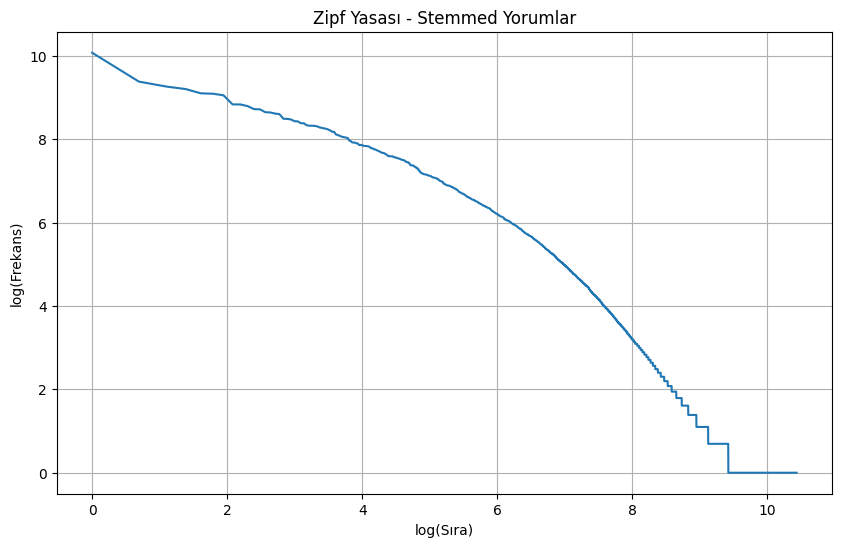

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import ast

# Veriyi oku
df = pd.read_csv("fordstemmed.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token listelerini birleştir
all_tokens = []

for row in df["Tokens_Stemmed"].dropna():
    if isinstance(row, str):
        try:
            tokens = ast.literal_eval(row)
            all_tokens.extend(tokens)
        except:
            continue

# Kelime frekanslarını say
word_freq = Counter(all_tokens)
sorted_freq = word_freq.most_common()

# Sıraları ve frekansları çıkar
ranks = np.arange(1, len(sorted_freq) + 1)
frequencies = [freq for word, freq in sorted_freq]

# Zipf log-log grafiğini çiz
plt.figure(figsize=(10, 6))
plt.plot(np.log(ranks), np.log(frequencies))
plt.title("Zipf Yasası - Stemmed Yorumlar")
plt.xlabel("log(Sıra)")
plt.ylabel("log(Frekans)")
plt.grid(True)
plt.show()


**ÖZELLİK KARŞILAŞTIRILMASI:**

| Özellik            | Lemmatized                 | Stemmed                  |
| ------------------ | -------------------------- | ------------------------ |
| Zipf eğrisi yapısı | Daha düzgün, anlamlı       | Daha kırık, agresif      |
| Dil doğallığı      | Daha yüksek                | Daha düşük               |
| Yapay kök riski    | Yok (sözlük tabanlı)       | Var                      |
| Uygunluk           | Zipf'e çok iyi uyum sağlar | Zipf'e genel olarak uyar |

----------------------------------------------------------------------

**YENİ VERİ BOYUTLARI:**

ford.csv --> 12,5 MB

fordlemmatized.csv --> 46,4 MB

fordstemmed.csv --> 46,2 MB

----------------------------------------------------------------------

**!!ÖNEMLİ UYARI!!**

"fordlemmatized.csv" ve "fordstemmed.csv" dosyalarında Pre-processing aşamalarında sütun eklendiği için ham dosya boyutundan büyük hale gelmişlerdir.

# **Vektörleştirme**

### **TF-IDF Vektörleştirme:**

**"fordlemmatized.csv" dosyası için TF-IDF Vektörleme İşlemi:**

| Özellik      | Açıklama                                                                                                                                                                                                    |
| ------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Satırlar** | `26,791` adet kullanıcı yorumu (lemmatized halde)                                                                                                                                                           |
| **Sütunlar** | `1000` adet kelime – TF-IDF değeri hesaplanan en sık geçen terimler                                                                                                                                         |
| **Hücreler** | Her bir hücre, o yorumda ilgili kelimenin önemini ifade eden **TF-IDF değeri**dir. Bu değer, kelimenin hem belge içinde ne kadar sık geçtiğini hem de tüm belgeler içinde ne kadar özgün olduğunu gösterir. |


**Yorum:**

Örneğin, 4. satırda "year" kelimesi için 0.1221 TF-IDF değeri var → Bu, bu yorumda “year” kelimesinin hem geçtiğini hem de genel yorumlar arasında özgün olduğunu gösterir.

0.0 olan hücreler, o kelimenin o yorumda hiç geçmediği anlamına gelir.




In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import ast

# Veriyi oku
df = pd.read_csv("fordlemmatized.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Tokens_Lemmatized sütununu metne dönüştür
def list_to_text(token_list_str):
    try:
        tokens = ast.literal_eval(token_list_str)
        return " ".join(tokens)
    except:
        return ""

# Metinleri oluştur
df["Processed_Text"] = df["Tokens_Lemmatized"].apply(list_to_text)

# TF-IDF vektörleştirici (en çok geçen 1000 kelime)
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df["Processed_Text"])

# TF-IDF DataFrame oluştur
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# CSV olarak kaydet
tfidf_df.to_csv("tfidf_lemmatized.csv", index=False)

# İlk 5 satırı kontrol
tfidf_df.head()


,04,05,06,07,08,10,100,1000,10000,100000,...,wow,wrong,xlt,year,yes,yet,youll,youre,yr,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.086621,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.122128,0.0,0.0,0.0,0.0,0.0,0.0


# **Vektörleştirme**

### **TF-IDF Vektörleştirme:**

**"fordstemmed.csv" dosyası için TF-IDF Vektörleme İşlemi:**

| Özellik         | Değer / Açıklama                                 |
| --------------- | ------------------------------------------------ |
| Satır Sayısı | 26,791 yorum → her satır bir belge/cümle         |
| Sütun Sayısı | 1000 kelime (en sık geçen 1000 terim)            |
| Hücre Değeri | TF-IDF değeri (kelimenin yorumdaki göreli önemi) |

İlk 1000 en sık geçen kelime vektör olarak yer alır. Örneğin:
"drive", "engin", "mileage", "perform", "safe" gibi stem’lenmiş kelimeler.

| year | perform | good | engine | drive |
| ---- | ------- | ---- | ------ | ----- |
| 0.12 | 0.08    | 0.00 | 0.03   | 0.10  |





In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import ast

# Veriyi oku
df = pd.read_csv("fordstemmed.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Tokens_Stemmed sütununu metne dönüştür
def list_to_text(token_list_str):
    try:
        tokens = ast.literal_eval(token_list_str)
        return " ".join(tokens)
    except:
        return ""

# Metinleri oluştur
df["Processed_Text"] = df["Tokens_Stemmed"].apply(list_to_text)

# TF-IDF vektörleştirici (sadece en sık geçen 1000 kelime)
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df["Processed_Text"])

# TF-IDF DataFrame oluştur
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# CSV olarak kaydet
tfidf_df.to_csv("tfidf_stemmed.csv", index=False)

# Kontrol için ilk 5 satır
tfidf_df.head()


,04,05,06,07,08,10,100,1000,10000,100000,...,wow,wrong,xlt,ye,year,yet,youll,your,yr,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.083231,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.126892,0.0,0.0,0.0,0.0,0.0


# **Vektörleştirme**

### **Word2Vec Vektörleştirme:**


**!GEREKLİ KÜTÜPHANELERİ İNDİRİN!**

In [2]:
!pip uninstall -y gensim numpy scipy


Found existing installation: gensim 4.3.1
Uninstalling gensim-4.3.1:
  Successfully uninstalled gensim-4.3.1
Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1


In [1]:
!pip install numpy==1.23.5 scipy==1.10.1 gensim==4.3.1


1. **"fordlemmatized.csv"** dosyasının

 **{'model_type': 'cbow', 'window': 2, 'vector_size': 100}**
 modelinde vektörlenmesi.

In [2]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordlemmatized.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Listeyi düzelt
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisi hazırla
sentences = df["Tokens_Lemmatized"].dropna().apply(parse_tokens).tolist()

# CBOW modeli eğit
model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=2,
    sg=0,            # CBOW
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_lemmatized_cbow_w2_d100.model")

# Kontrol: benzer kelimeler
print(model.wv.most_similar("car", topn=5))


[('vehicle', 0.8198708295822144), ('truck', 0.7185949683189392), ('van', 0.6296799778938293), ('suv', 0.6098203063011169), ('carit', 0.5903662443161011)]


2. **"fordlemmatized.csv"** dosyasının

 **{'model_type': 'skipgram', 'window': 2, 'vector_size': 100}**
 modelinde vektörlenmesi.

In [3]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordlemmatized.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token listesini dönüştür
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisini hazırla
sentences = df["Tokens_Lemmatized"].dropna().apply(parse_tokens).tolist()

# Word2Vec modelini eğit (Skip-gram: sg=1)
model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=2,
    sg=1,            # Skip-gram
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_lemmatized_skipgram_w2_d100.model")

# Kontrol için örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('vehicle', 0.8841084241867065), ('truck', 0.8296645283699036), ('cari', 0.8141257166862488), ('carit', 0.8088990449905396), ('itthis', 0.7689590454101562)]


3. **"fordlemmatized.csv"** dosyasının

 **{'model_type': 'cbow', 'window': 4, 'vector_size': 100}**
 modelinde vektörlenmesi.

In [4]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordlemmatized.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token listesini düzenle
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisini oluştur
sentences = df["Tokens_Lemmatized"].dropna().apply(parse_tokens).tolist()

# CBOW modelini eğit (window=4, v=100)
model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=4,
    sg=0,            # CBOW
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_lemmatized_cbow_w4_d100.model")

# Kontrol: örnek kelime benzerlikleri
print(model.wv.most_similar("car", topn=5))


[('vehicle', 0.7630560398101807), ('truck', 0.6456139087677002), ('excitementright', 0.5359010696411133), ('suv', 0.5164809823036194), ('personsmall', 0.4707830548286438)]


4. **"fordlemmatized.csv"** dosyasının

 **{'model_type': 'skipgram', 'window': 4, 'vector_size': 100}**
 modelinde vektörlenmesi.

In [5]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordlemmatized.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token listesini dönüştür
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisi (her yorum bir token listesi)
sentences = df["Tokens_Lemmatized"].dropna().apply(parse_tokens).tolist()

# Skip-gram modeli eğit (window=4, vector_size=100)
model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=4,
    sg=1,            # Skip-gram
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_lemmatized_skipgram_w4_d100.model")

# Kontrol için örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('vehicle', 0.832505464553833), ('beater', 0.8059041500091553), ('untill', 0.7934473752975464), ('vehical', 0.7912529110908508), ('carit', 0.776904821395874)]


5. **"fordlemmatized.csv"** dosyasının

 **{'model_type': 'cbow', 'window': 2, 'vector_size': 300}**
 modelinde vektörlenmesi.

In [6]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordlemmatized.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token listesini gerçek listeye dönüştür
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisi
sentences = df["Tokens_Lemmatized"].dropna().apply(parse_tokens).tolist()

# CBOW modeli eğit (vector_size=300, window=2)
model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=2,
    sg=0,            # CBOW
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_lemmatized_cbow_w2_d300.model")

# Örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('vehicle', 0.7796017527580261), ('truck', 0.6977925300598145), ('van', 0.5820302963256836), ('suv', 0.5737636685371399), ('carit', 0.5596029758453369)]


6. **"fordlemmatized.csv"** dosyasının

 **{'model_type': 'skipgram', 'window': 2, 'vector_size': 300}**
 modelinde vektörlenmesi.

In [7]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordlemmatized.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token liste dönüşüm fonksiyonu
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisini oluştur
sentences = df["Tokens_Lemmatized"].dropna().apply(parse_tokens).tolist()

# Skip-gram modeli eğit (vector_size=300, window=2)
model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=2,
    sg=1,            # Skip-gram
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_lemmatized_skipgram_w2_d300.model")

# Örnek çıktı (isteğe bağlı)
print(model.wv.most_similar("car", topn=5))


[('carit', 0.7474758625030518), ('cari', 0.7322416305541992), ('vehicle', 0.7194352746009827), ('untill', 0.6940665245056152), ('carsuv', 0.6902461647987366)]


7. **"fordlemmatized.csv"** dosyasının

 **{'model_type': 'cbow', 'window': 4, 'vector_size': 300}**
 modelinde vektörlenmesi.

In [8]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordlemmatized.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Liste dönüşüm fonksiyonu
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisi: her yorum bir token listesi
sentences = df["Tokens_Lemmatized"].dropna().apply(parse_tokens).tolist()

# CBOW modeli eğit (window=4, vector_size=300)
model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=4,
    sg=0,            # CBOW
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_lemmatized_cbow_w4_d300.model")

# Kontrol: benzer kelimeler
print(model.wv.most_similar("car", topn=5))


[('vehicle', 0.7428813576698303), ('truck', 0.5473042130470276), ('suv', 0.5024571418762207), ('van', 0.46582847833633423), ('focus', 0.4555650055408478)]


8. **"fordlemmatized.csv"** dosyasının

 **{'model_type': 'skipgram', 'window': 4, 'vector_size': 300}**
 modelinde vektörlenmesi.

In [9]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordlemmatized.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Liste dönüşüm fonksiyonu
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisi oluştur
sentences = df["Tokens_Lemmatized"].dropna().apply(parse_tokens).tolist()

# Skip-gram modeli eğit (vector_size=300, window=4)
model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=4,
    sg=1,            # Skip-gram
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_lemmatized_skipgram_w4_d300.model")

# Örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('carit', 0.7210293412208557), ('untill', 0.7141173481941223), ('vehicle', 0.7038291096687317), ('beater', 0.7022868990898132), ('girlfriend', 0.7006089091300964)]


9. **"fordstemmed.csv"** dosyasının

 **{'model_type': 'cbow', 'window': 2, 'vector_size': 100}**
 modelinde vektörlenmesi.

In [10]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordstemmed.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token sütununu listeye çevir
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisini oluştur
sentences = df["Tokens_Stemmed"].dropna().apply(parse_tokens).tolist()

# CBOW modeli eğit (window=2, vector_size=100)
model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=2,
    sg=0,            # CBOW
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_stemmed_cbow_w2_d100.model")

# Örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('vehicl', 0.8389149308204651), ('truck', 0.75408536195755), ('suv', 0.6130533218383789), ('van', 0.6024304628372192), ('carit', 0.5742932558059692)]


10. **"fordstemmed.csv"** dosyasının

 **{'model_type': 'skipgram', 'window': 2, 'vector_size': 100}**
 modelinde vektörlenmesi.

In [11]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordstemmed.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token sütununu listeye çevir
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisini oluştur
sentences = df["Tokens_Stemmed"].dropna().apply(parse_tokens).tolist()

# Skip-gram modeli eğit (window=2, vector_size=100)
model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=2,
    sg=1,            # Skip-gram
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_stemmed_skipgram_w2_d100.model")

# Örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('vehicl', 0.880066454410553), ('truck', 0.8359362483024597), ('carit', 0.8321475386619568), ('vehic', 0.7972906827926636), ('cari', 0.7857321500778198)]


11. **"fordstemmed.csv"** dosyasının

 **{'model_type': 'cbow', 'window': 4, 'vector_size': 100}**
 modelinde vektörlenmesi.

In [12]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordstemmed.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token listesini string'ten gerçek listeye çevir
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisini oluştur
sentences = df["Tokens_Stemmed"].dropna().apply(parse_tokens).tolist()

# CBOW modeli eğit (window=4, vector_size=100)
model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=4,
    sg=0,            # CBOW
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_stemmed_cbow_w4_d100.model")

# Örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('vehicl', 0.7524600028991699), ('truck', 0.6389753818511963), ('suv', 0.4981040954589844), ('one', 0.47868290543556213), ('automobil', 0.47241559624671936)]


12. **"fordstemmed.csv"** dosyasının

 **{'model_type': 'skipgram', 'window': 4, 'vector_size': 100}**
 modelinde vektörlenmesi.

In [13]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordstemmed.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Liste formatına dönüştür
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisini hazırla
sentences = df["Tokens_Stemmed"].dropna().apply(parse_tokens).tolist()

# Skip-gram modeli eğit (window=4, vector_size=100)
model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=4,
    sg=1,            # Skip-gram
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_stemmed_skipgram_w4_d100.model")

# Örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('vehicl', 0.8443935513496399), ('carit', 0.8233303427696228), ('beater', 0.810287356376648), ('vehic', 0.7992797493934631), ('beginn', 0.7900424003601074)]


13. **"fordstemmed.csv"** dosyasının

 **{'model_type': 'cbow', 'window': 2, 'vector_size': 300}**
 modelinde vektörlenmesi.

In [14]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordstemmed.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token listesini string'ten gerçek listeye çevir
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisi hazırla
sentences = df["Tokens_Stemmed"].dropna().apply(parse_tokens).tolist()

# CBOW modeli eğit (window=2, vector_size=300)
model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=2,
    sg=0,            # CBOW
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_stemmed_cbow_w2_d300.model")

# Örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('vehicl', 0.7504967451095581), ('truck', 0.6768946647644043), ('suv', 0.5647554993629456), ('cari', 0.5602006912231445), ('carit', 0.5537517666816711)]


14. **"fordstemmed.csv"** dosyasının

 **{'model_type': 'skipgram', 'window': 2, 'vector_size': 300}**
 modelinde vektörlenmesi.

In [15]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordstemmed.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token listesini düzelt
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisi
sentences = df["Tokens_Stemmed"].dropna().apply(parse_tokens).tolist()

# Skip-gram modeli eğit (window=2, vector_size=300)
model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=2,
    sg=1,            # Skip-gram
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_stemmed_skipgram_w2_d300.model")

# Örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('carit', 0.7519824504852295), ('vehicl', 0.7371336817741394), ('vehic', 0.7180671095848083), ('cari', 0.7082736492156982), ('until', 0.7059272527694702)]


15. **"fordstemmed.csv"** dosyasının

 **{'model_type': 'cbow', 'window': 4, 'vector_size': 300}**
 modelinde vektörlenmesi.

In [16]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordstemmed.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token listesini string'ten listeye çevir
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisi oluştur
sentences = df["Tokens_Stemmed"].dropna().apply(parse_tokens).tolist()

# CBOW modeli eğit (window=4, vector_size=300)
model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=4,
    sg=0,            # CBOW
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_stemmed_cbow_w4_d300.model")

# Örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('vehicl', 0.7124595046043396), ('truck', 0.5723068118095398), ('suv', 0.49677902460098267), ('itÃ£\x83Ã¢Â£Ã£\x82Ã¢Â£', 0.49105462431907654), ('towtruck', 0.4809557795524597)]


16. **"fordstemmed.csv"** dosyasının

 **{'model_type': 'skipgram', 'window': 4, 'vector_size': 300}**
 modelinde vektörlenmesi.

In [17]:
import pandas as pd
import ast
from gensim.models import Word2Vec

# Veriyi oku
df = pd.read_csv("fordstemmed.csv", encoding='latin1', engine='python', on_bad_lines='skip')

# Token listesini düzelt
def parse_tokens(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

# Eğitim verisi oluştur
sentences = df["Tokens_Stemmed"].dropna().apply(parse_tokens).tolist()

# Skip-gram modeli eğit (window=4, vector_size=300)
model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=4,
    sg=1,            # Skip-gram
    min_count=1,
    workers=4,
    epochs=10
)

# Modeli kaydet
model.save("word2vec_stemmed_skipgram_w4_d300.model")

# Örnek çıktı
print(model.wv.most_similar("car", topn=5))


[('beater', 0.7375115752220154), ('vehic', 0.7144360542297363), ('vehicl', 0.6952458620071411), ('carit', 0.6951813101768494), ('statu', 0.6914921998977661)]


# **ÖDEV-2 BAŞLANGIÇ**

##**GÖREV-1:**

Ödev-1 çıktısı olan:

2 adet temiz veri seti: lemmatized.csv, stemmed.csv

2 TF-IDF modeli (1 tf-idf_lemmatized, 1 tf-idf_stemmed)

16 Word2Vec modeli (8 lemmatized, 8 stemmed)
dosyaları hali hazırda proje içerisinde yer almaktadır.

##**GÖREV-2A(TF-IDF Vektörleştirme):**
**Seçilen giriş metni: veri kümesindeki 7. satır** ['lot', 'problem', 'ford', 'day', 'sensor', 'issu', 'cam', 'phaser', 'got', 'solenoid', 'problem']


**!! Gerekli paketlerin indirilmesi!!**

In [18]:
pip install pandas scikit-learn


**Stemmed TF-IDF Benzerliği:**

TF-IDF (Stemmed) - En Benzer 5 Metin:
1. Satır No: 12996, Benzerlik Skoru: 0.2145
2. Satır No: 1521, Benzerlik Skoru: 0.2026
3. Satır No: 665, Benzerlik Skoru: 0.2014
4. Satır No: 10159, Benzerlik Skoru: 0.1945
5. Satır No: 22091, Benzerlik Skoru: 0.1923


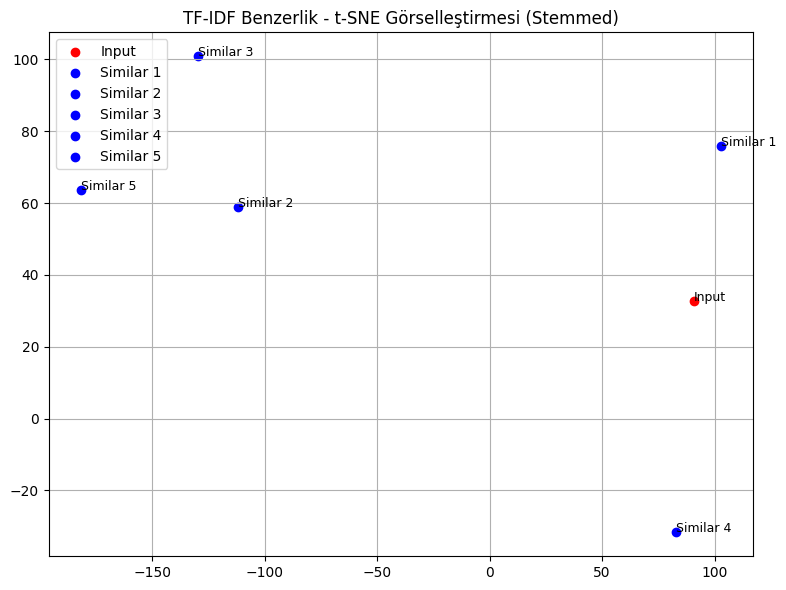

In [22]:
import pandas as pd
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini oku
df = pd.read_csv("fordstemmed.csv")

# 2. 'Tokens_Stemmed' sütununu listeye çevir
texts = df["Tokens_Stemmed"].astype(str).apply(ast.literal_eval)

# 3. Listeyi düz metne çevir
sentences = texts.apply(lambda tokens: " ".join(tokens))

# 4. TF-IDF vektörlemesi
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(sentences)

# 5. Giriş metni index'i
input_index = 6
input_vector = tfidf_matrix[input_index]

# 6. Cosine similarity hesapla
similarities = cosine_similarity(input_vector, tfidf_matrix)[0]

# 7. En benzer 5 metni bul (kendisi hariç)
top_indices = similarities.argsort()[::-1]
top_indices = [i for i in top_indices if i != input_index][:5]
top_scores = similarities[top_indices]

# 8. Sonuçları yazdır
print("TF-IDF (Stemmed) - En Benzer 5 Metin:")
for i, (index, score) in enumerate(zip(top_indices, top_scores)):
    print(f"{i+1}. Satır No: {index}, Benzerlik Skoru: {score:.4f}")

# 9. Görselleştirme için vektörleri seç (giriş + ilk 5 benzer)
selected_indices = [input_index] + top_indices
selected_vectors = tfidf_matrix[selected_indices].toarray()

# 10. t-SNE ile 2D'ye indir (perplexity değeri düşük)
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(selected_vectors)

# 11. Görselleştir
plt.figure(figsize=(8, 6))
colors = ['red'] + ['blue'] * 5
labels = ['Input'] + [f"Similar {i+1}" for i in range(5)]

for i, (vec, label) in enumerate(zip(reduced_vectors, labels)):
    plt.scatter(vec[0], vec[1], color=colors[i], label=label)
    plt.text(vec[0]+0.01, vec[1]+0.01, label, fontsize=9)

plt.title("TF-IDF Benzerlik - t-SNE Görselleştirmesi (Stemmed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Lemmatized TF-IDF Benzerliği:**

TF-IDF (Lemmatized) - En Benzer 5 Metin:
1. Satır No: 12996, Benzerlik Skoru: 0.2155
2. Satır No: 665, Benzerlik Skoru: 0.1988
3. Satır No: 10159, Benzerlik Skoru: 0.1914
4. Satır No: 16047, Benzerlik Skoru: 0.1874
5. Satır No: 208, Benzerlik Skoru: 0.1811


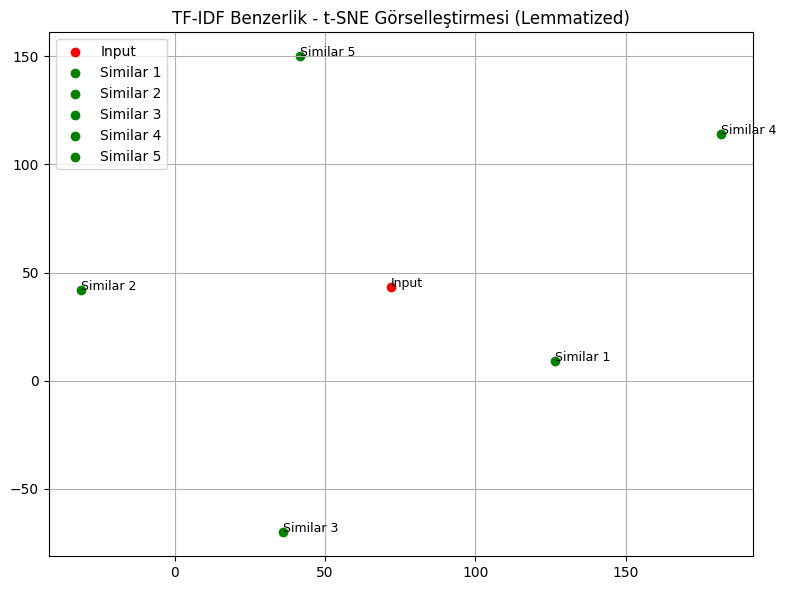

In [23]:
import pandas as pd
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini oku
df = pd.read_csv("fordlemmatized.csv")

# 2. 'Tokens_Lemmatized' sütununu listeye çevir
texts = df["Tokens_Lemmatized"].astype(str).apply(ast.literal_eval)

# 3. Listeyi düz metne çevir
sentences = texts.apply(lambda tokens: " ".join(tokens))

# 4. TF-IDF vektörlemesi
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(sentences)

# 5. Giriş metni index'i (aynı: 6. satır)
input_index = 6
input_vector = tfidf_matrix[input_index]

# 6. Cosine similarity hesapla
similarities = cosine_similarity(input_vector, tfidf_matrix)[0]

# 7. En benzer 5 metni bul (kendisi hariç)
top_indices = similarities.argsort()[::-1]
top_indices = [i for i in top_indices if i != input_index][:5]
top_scores = similarities[top_indices]

# 8. Sonuçları yazdır
print("TF-IDF (Lemmatized) - En Benzer 5 Metin:")
for i, (index, score) in enumerate(zip(top_indices, top_scores)):
    print(f"{i+1}. Satır No: {index}, Benzerlik Skoru: {score:.4f}")

# 9. Görselleştirme için vektörleri seç (giriş + ilk 5 benzer)
selected_indices = [input_index] + top_indices
selected_vectors = tfidf_matrix[selected_indices].toarray()

# 10. t-SNE ile 2D'ye indir (perplexity düşük)
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(selected_vectors)

# 11. Görselleştir
plt.figure(figsize=(8, 6))
colors = ['red'] + ['green'] * 5
labels = ['Input'] + [f"Similar {i+1}" for i in range(5)]

for i, (vec, label) in enumerate(zip(reduced_vectors, labels)):
    plt.scatter(vec[0], vec[1], color=colors[i], label=label)
    plt.text(vec[0]+0.01, vec[1]+0.01, label, fontsize=9)

plt.title("TF-IDF Benzerlik - t-SNE Görselleştirmesi (Lemmatized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**TF-IDF Vektörlerinin Karşılaştırması**

In [25]:
import pandas as pd

# Kullanıcıdan verilen puanları gir (örnek olarak yazılmıştır)
tfidf_stemmed_scores = [4, 2, 2, 4, 2]
tfidf_lemmatized_scores = [4, 2, 2, 5, 2]

# Ortalama puanları hesapla
avg_stemmed = sum(tfidf_stemmed_scores) / len(tfidf_stemmed_scores)
avg_lemmatized = sum(tfidf_lemmatized_scores) / len(tfidf_lemmatized_scores)

# Verileri tablo haline getir
df_eval = pd.DataFrame({
    "Model": ["TF-IDF Stemmed", "TF-IDF Lemmatized"],
    "Puanlar": [tfidf_stemmed_scores, tfidf_lemmatized_scores],
    "Ortalama Puan": [avg_stemmed, avg_lemmatized]
})

# Sonucu yazdır
print("TF-IDF Modelleri Anlamsal Değerlendirme Karşılaştırması:")
print(df_eval)

# Yorum
if avg_lemmatized > avg_stemmed:
    print("\n👉 TF-IDF Lemmatized modeli daha anlamlı sonuçlar üretmiştir.")
elif avg_stemmed > avg_lemmatized:
    print("\n👉 TF-IDF Stemmed modeli daha anlamlı sonuçlar üretmiştir.")
else:
    print("\n👉 Her iki model de benzer başarı göstermiştir.")


TF-IDF Modelleri Anlamsal Değerlendirme Karşılaştırması:
               Model          Puanlar  Ortalama Puan
0     TF-IDF Stemmed  [4, 2, 2, 4, 2]            2.8
1  TF-IDF Lemmatized  [4, 2, 2, 5, 2]            3.0

👉 TF-IDF Lemmatized modeli daha anlamlı sonuçlar üretmiştir.


##**GÖREV-2B(Word2Vec Vektörleştirme):**
**Seçilen giriş metni: veri kümesindeki 7. satır** ['lot', 'problem', 'ford', 'day', 'sensor', 'issu', 'cam', 'phaser', 'got', 'solenoid', 'problem']


**"word2vec_stemmed_cbow_w2_d100.model" Modeli için hesaplama:**

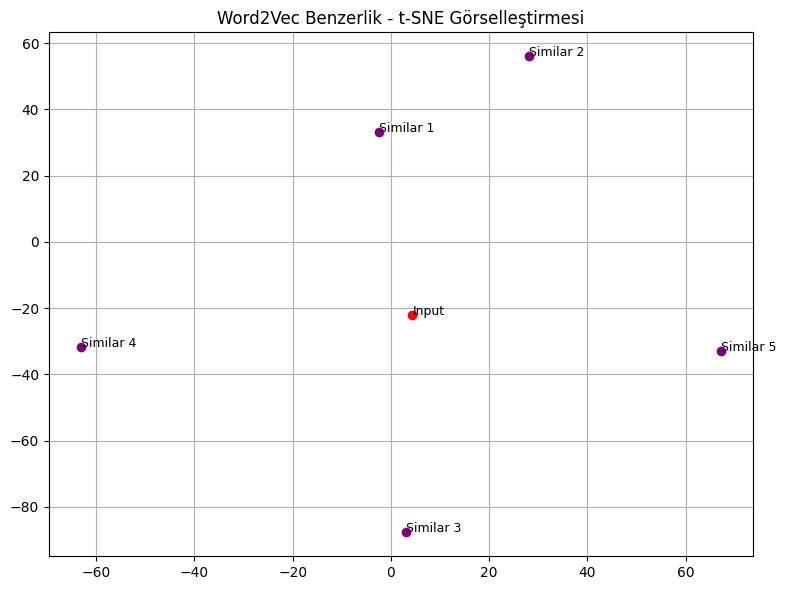


Word2Vec (Stemmed CBOW W2 D100) - En Benzer 5 Metin:
1. Satır No: 5758, Benzerlik Skoru: 0.9511
2. Satır No: 7205, Benzerlik Skoru: 0.9510
3. Satır No: 15045, Benzerlik Skoru: 0.9505
4. Satır No: 19322, Benzerlik Skoru: 0.9477
5. Satır No: 9308, Benzerlik Skoru: 0.9474


In [28]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordstemmed.csv")
df["Tokens_Stemmed"] = df["Tokens_Stemmed"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Stemmed"]

# 3. Word2Vec modelini yükle (örnek model)
model = Word2Vec.load("word2vec_stemmed_cbow_w2_d100.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Stemmed"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörleri görselleştirme için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["purple"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))


# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec Benzerlik - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Stemmed CBOW W2 D100) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_stemmed_skipgram_w2_d100.model" Modeli için hesaplama:**

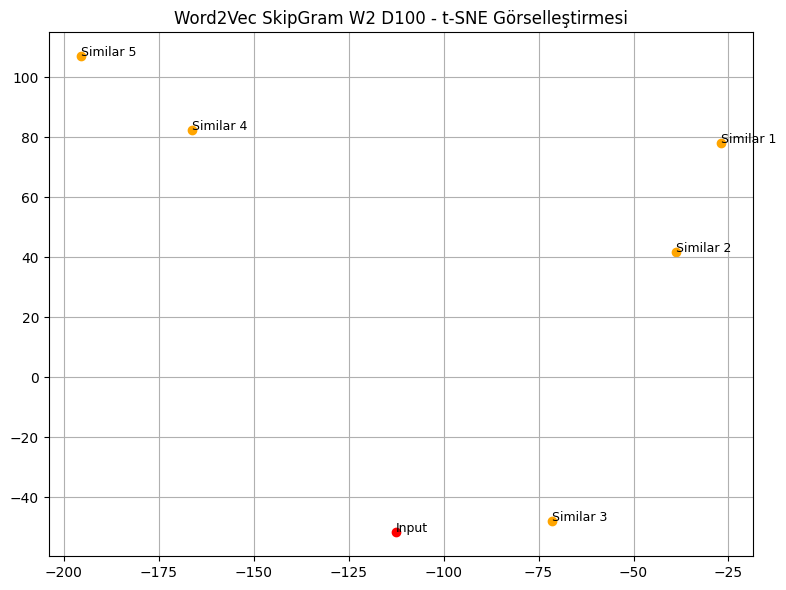


Word2Vec (Stemmed SkipGram W2 D100) - En Benzer 5 Metin:
1. Satır No: 14609, Benzerlik Skoru: 0.9786
2. Satır No: 10501, Benzerlik Skoru: 0.9783
3. Satır No: 5855, Benzerlik Skoru: 0.9783
4. Satır No: 7205, Benzerlik Skoru: 0.9782
5. Satır No: 5758, Benzerlik Skoru: 0.9771


In [29]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordstemmed.csv")
df["Tokens_Stemmed"] = df["Tokens_Stemmed"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Stemmed"]

# 3. Word2Vec modelini yükle (şu model: SkipGram W2 D100)
model = Word2Vec.load("word2vec_stemmed_skipgram_w2_d100.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Stemmed"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["orange"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec SkipGram W2 D100 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Stemmed SkipGram W2 D100) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_stemmed_cbow_w4_d100.model" Modeli için hesaplama:**

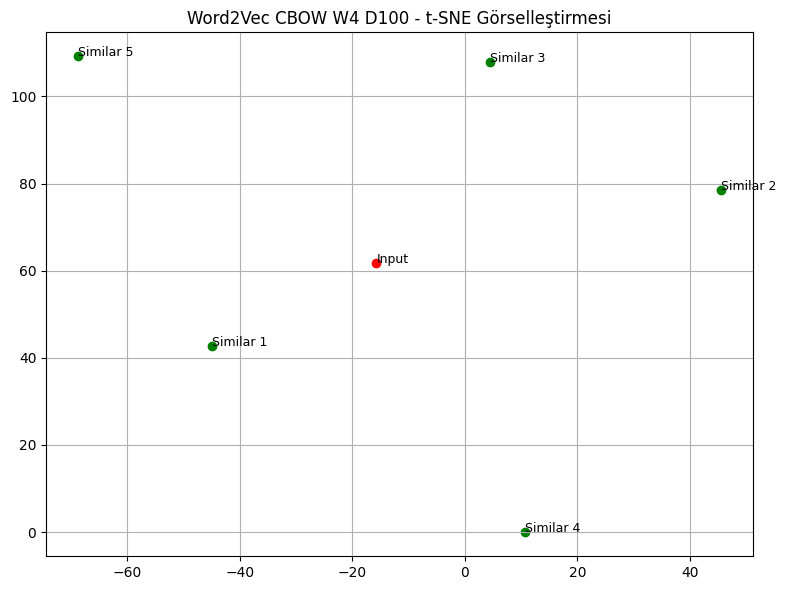


Word2Vec (Stemmed CBOW W4 D100) - En Benzer 5 Metin:
1. Satır No: 15045, Benzerlik Skoru: 0.9164
2. Satır No: 14586, Benzerlik Skoru: 0.9161
3. Satır No: 14692, Benzerlik Skoru: 0.9159
4. Satır No: 17332, Benzerlik Skoru: 0.9133
5. Satır No: 18451, Benzerlik Skoru: 0.9110


In [30]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordstemmed.csv")
df["Tokens_Stemmed"] = df["Tokens_Stemmed"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Stemmed"]

# 3. Word2Vec modelini yükle (şu model: CBOW W4 D100)
model = Word2Vec.load("word2vec_stemmed_cbow_w4_d100.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Stemmed"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["green"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec CBOW W4 D100 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Stemmed CBOW W4 D100) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_stemmed_skipgram_w4_d100.model" Modeli için hesaplama:**

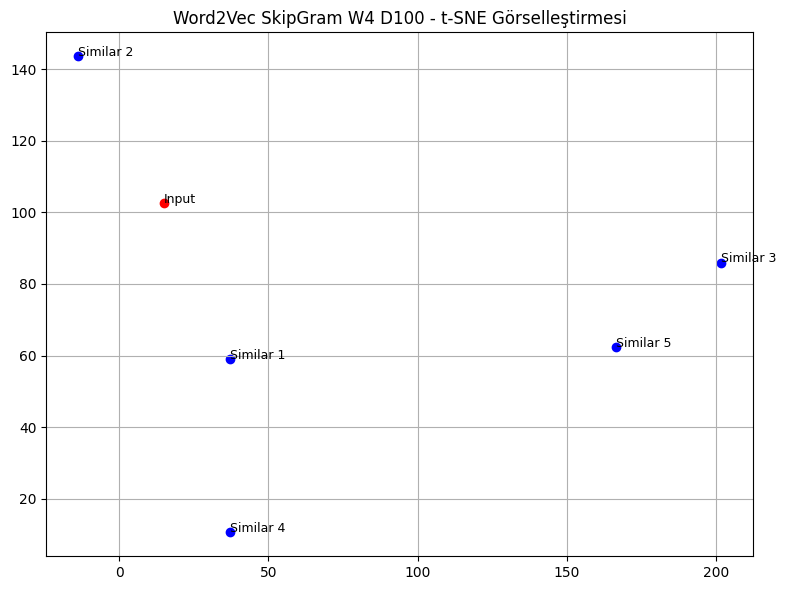


Word2Vec (Stemmed SkipGram W4 D100) - En Benzer 5 Metin:
1. Satır No: 14949, Benzerlik Skoru: 0.9768
2. Satır No: 5758, Benzerlik Skoru: 0.9757
3. Satır No: 14692, Benzerlik Skoru: 0.9749
4. Satır No: 4836, Benzerlik Skoru: 0.9738
5. Satır No: 14609, Benzerlik Skoru: 0.9731


In [31]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordstemmed.csv")
df["Tokens_Stemmed"] = df["Tokens_Stemmed"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Stemmed"]

# 3. Word2Vec modelini yükle (şu model: SkipGram W4 D100)
model = Word2Vec.load("word2vec_stemmed_skipgram_w4_d100.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Stemmed"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["blue"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec SkipGram W4 D100 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Stemmed SkipGram W4 D100) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_stemmed_cbow_w2_d300.model" Modeli için hesaplama:**


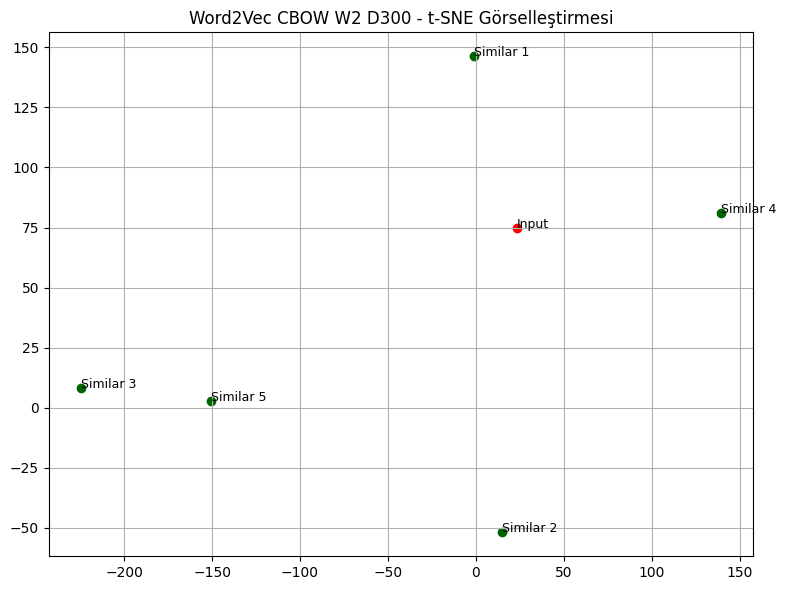


Word2Vec (Stemmed CBOW W2 D300) - En Benzer 5 Metin:
1. Satır No: 15045, Benzerlik Skoru: 0.9494
2. Satır No: 19322, Benzerlik Skoru: 0.9473
3. Satır No: 14586, Benzerlik Skoru: 0.9469
4. Satır No: 13687, Benzerlik Skoru: 0.9468
5. Satır No: 14609, Benzerlik Skoru: 0.9462


In [32]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordstemmed.csv")
df["Tokens_Stemmed"] = df["Tokens_Stemmed"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Stemmed"]

# 3. Word2Vec modelini yükle (şu model: CBOW W2 D300)
model = Word2Vec.load("word2vec_stemmed_cbow_w2_d300.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Stemmed"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["darkgreen"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec CBOW W2 D300 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Stemmed CBOW W2 D300) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_stemmed_skipgram_w2_d300.model" Modeli için hesaplama:**


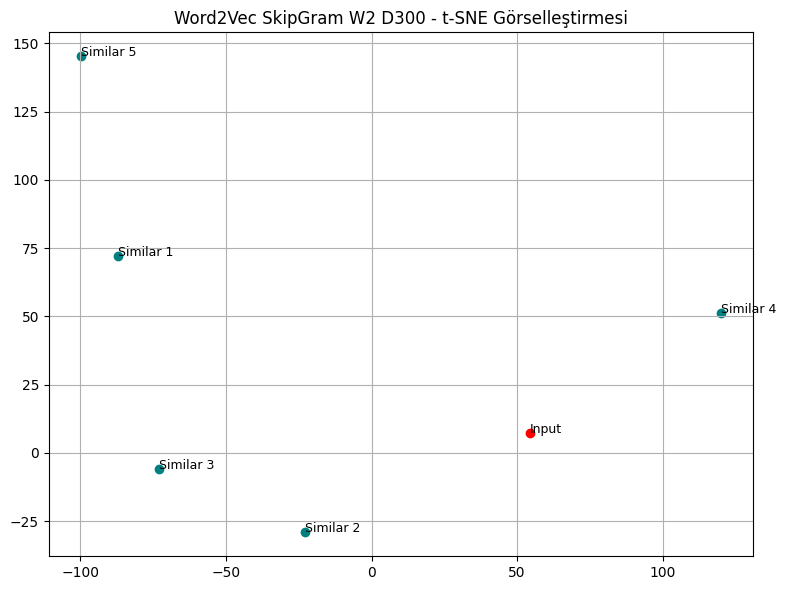


Word2Vec (Stemmed SkipGram W2 D300) - En Benzer 5 Metin:
1. Satır No: 14609, Benzerlik Skoru: 0.9731
2. Satır No: 7205, Benzerlik Skoru: 0.9714
3. Satır No: 13687, Benzerlik Skoru: 0.9713
4. Satır No: 14911, Benzerlik Skoru: 0.9713
5. Satır No: 14692, Benzerlik Skoru: 0.9711


In [33]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordstemmed.csv")
df["Tokens_Stemmed"] = df["Tokens_Stemmed"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Stemmed"]

# 3. Word2Vec modelini yükle (şu model: SkipGram W2 D300)
model = Word2Vec.load("word2vec_stemmed_skipgram_w2_d300.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Stemmed"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["teal"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec SkipGram W2 D300 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Stemmed SkipGram W2 D300) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_stemmed_cbow_w4_d300.model" Modeli için hesaplama:**


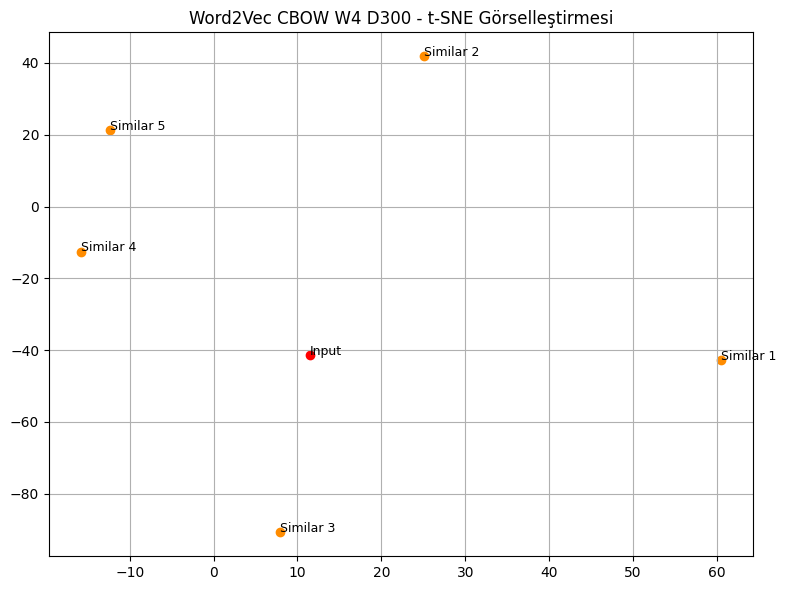


Word2Vec (Stemmed CBOW W4 D300) - En Benzer 5 Metin:
1. Satır No: 14692, Benzerlik Skoru: 0.9203
2. Satır No: 14609, Benzerlik Skoru: 0.9124
3. Satır No: 14586, Benzerlik Skoru: 0.9121
4. Satır No: 15045, Benzerlik Skoru: 0.9099
5. Satır No: 10501, Benzerlik Skoru: 0.9098


In [34]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordstemmed.csv")
df["Tokens_Stemmed"] = df["Tokens_Stemmed"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Stemmed"]

# 3. Word2Vec modelini yükle (CBOW W4 D300)
model = Word2Vec.load("word2vec_stemmed_cbow_w4_d300.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Stemmed"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["darkorange"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec CBOW W4 D300 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Stemmed CBOW W4 D300) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_stemmed_skipgram_w4_d300.model" Modeli için hesaplama:**


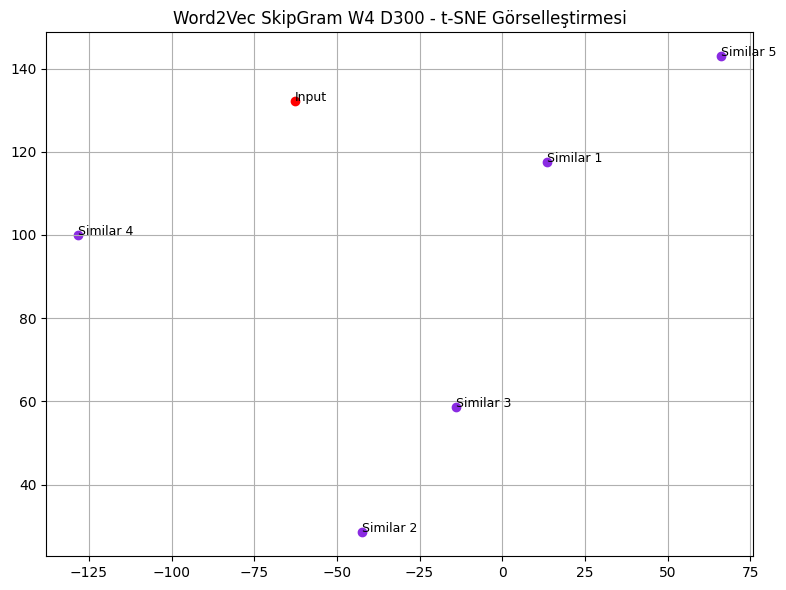


Word2Vec (Stemmed SkipGram W4 D300) - En Benzer 5 Metin:
1. Satır No: 14609, Benzerlik Skoru: 0.9676
2. Satır No: 5758, Benzerlik Skoru: 0.9657
3. Satır No: 7205, Benzerlik Skoru: 0.9635
4. Satır No: 2636, Benzerlik Skoru: 0.9633
5. Satır No: 14692, Benzerlik Skoru: 0.9633


In [35]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordstemmed.csv")
df["Tokens_Stemmed"] = df["Tokens_Stemmed"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Stemmed"]

# 3. Word2Vec modelini yükle (SkipGram W4 D300)
model = Word2Vec.load("word2vec_stemmed_skipgram_w4_d300.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Stemmed"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["blueviolet"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec SkipGram W4 D300 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Stemmed SkipGram W4 D300) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_lemmatized_cbow_w2_d100.model" Modeli için hesaplama:**


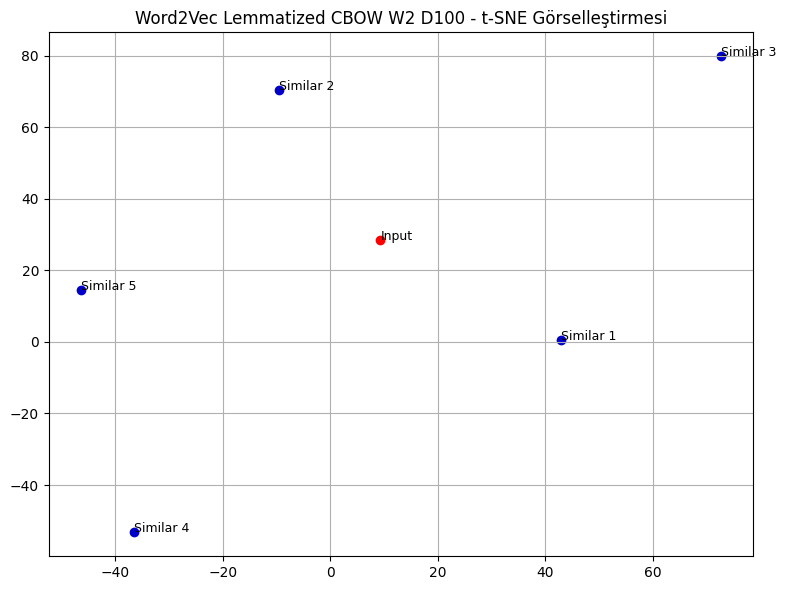


Word2Vec (Lemmatized CBOW W2 D100) - En Benzer 5 Metin:
1. Satır No: 8800, Benzerlik Skoru: 0.9522
2. Satır No: 5758, Benzerlik Skoru: 0.9521
3. Satır No: 17008, Benzerlik Skoru: 0.9519
4. Satır No: 19322, Benzerlik Skoru: 0.9505
5. Satır No: 14609, Benzerlik Skoru: 0.9501


In [36]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordlemmatized.csv")
df["Tokens_Lemmatized"] = df["Tokens_Lemmatized"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Lemmatized"]

# 3. Word2Vec modelini yükle (CBOW W2 D100)
model = Word2Vec.load("word2vec_lemmatized_cbow_w2_d100.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Lemmatized"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["mediumblue"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec Lemmatized CBOW W2 D100 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Lemmatized CBOW W2 D100) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_lemmatized_skipgram_w2_d100.model" Modeli için hesaplama:**


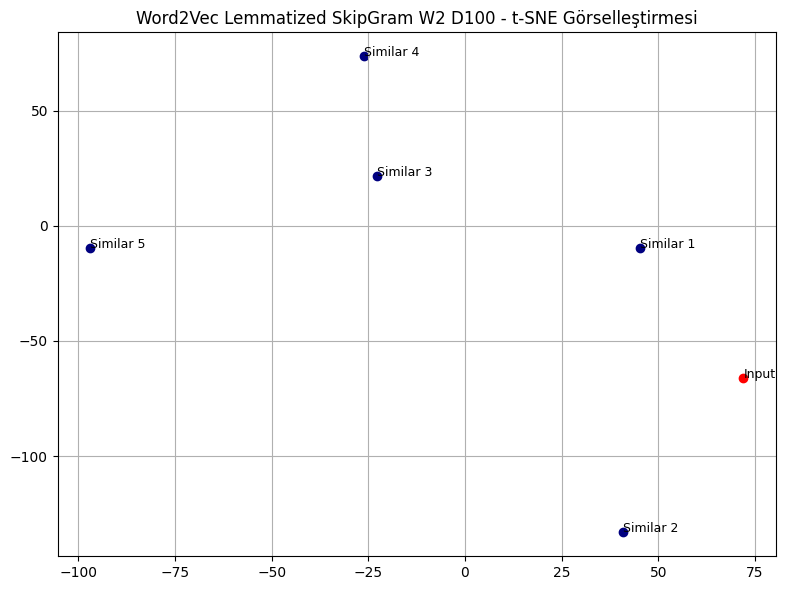


Word2Vec (Lemmatized SkipGram W2 D100) - En Benzer 5 Metin:
1. Satır No: 7205, Benzerlik Skoru: 0.9785
2. Satır No: 10330, Benzerlik Skoru: 0.9762
3. Satır No: 14609, Benzerlik Skoru: 0.9762
4. Satır No: 15148, Benzerlik Skoru: 0.9759
5. Satır No: 19322, Benzerlik Skoru: 0.9752


In [37]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordlemmatized.csv")
df["Tokens_Lemmatized"] = df["Tokens_Lemmatized"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Lemmatized"]

# 3. Word2Vec modelini yükle (SkipGram W2 D100)
model = Word2Vec.load("word2vec_lemmatized_skipgram_w2_d100.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Lemmatized"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["navy"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec Lemmatized SkipGram W2 D100 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Lemmatized SkipGram W2 D100) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_lemmatized_cbow_w4_d100.model" Modeli için hesaplama:**


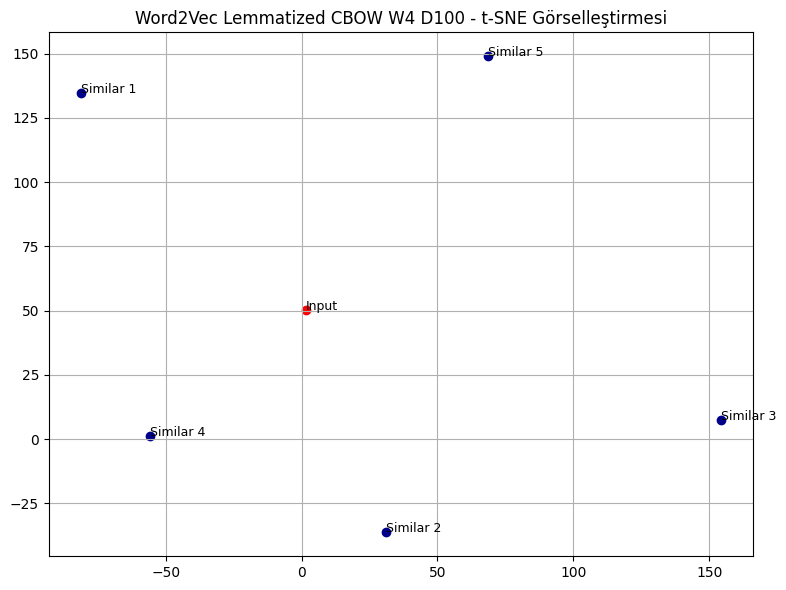


Word2Vec (Lemmatized CBOW W4 D100) - En Benzer 5 Metin:
1. Satır No: 3015, Benzerlik Skoru: 0.9206
2. Satır No: 14609, Benzerlik Skoru: 0.9205
3. Satır No: 19322, Benzerlik Skoru: 0.9184
4. Satır No: 14771, Benzerlik Skoru: 0.9179
5. Satır No: 17008, Benzerlik Skoru: 0.9149


In [38]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordlemmatized.csv")
df["Tokens_Lemmatized"] = df["Tokens_Lemmatized"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Lemmatized"]

# 3. Word2Vec modelini yükle (CBOW W4 D100)
model = Word2Vec.load("word2vec_lemmatized_cbow_w4_d100.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Lemmatized"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["darkblue"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec Lemmatized CBOW W4 D100 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Lemmatized CBOW W4 D100) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_lemmatized_skipgram_w4_d100.model" Modeli için hesaplama:**


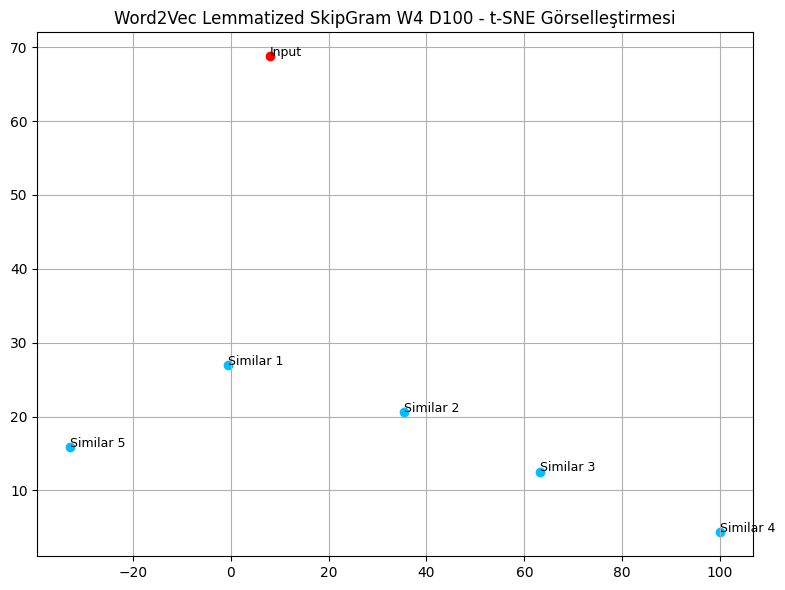


Word2Vec (Lemmatized SkipGram W4 D100) - En Benzer 5 Metin:
1. Satır No: 14609, Benzerlik Skoru: 0.9710
2. Satır No: 7205, Benzerlik Skoru: 0.9696
3. Satır No: 5758, Benzerlik Skoru: 0.9683
4. Satır No: 1272, Benzerlik Skoru: 0.9681
5. Satır No: 10330, Benzerlik Skoru: 0.9679


In [39]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordlemmatized.csv")
df["Tokens_Lemmatized"] = df["Tokens_Lemmatized"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Lemmatized"]

# 3. Word2Vec modelini yükle (SkipGram W4 D100)
model = Word2Vec.load("word2vec_lemmatized_skipgram_w4_d100.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Lemmatized"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["deepskyblue"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec Lemmatized SkipGram W4 D100 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Lemmatized SkipGram W4 D100) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_lemmatized_cbow_w2_d300.model" Modeli için hesaplama:**


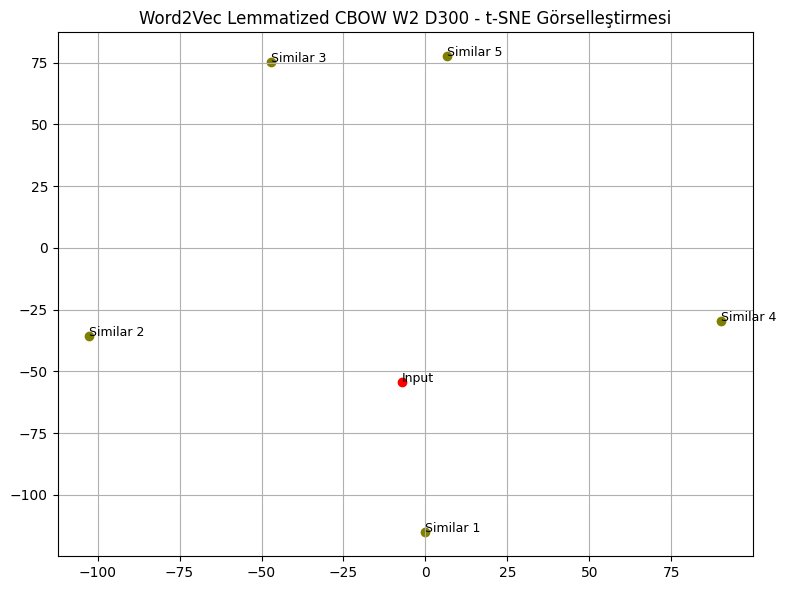


Word2Vec (Lemmatized CBOW W2 D300) - En Benzer 5 Metin:
1. Satır No: 8800, Benzerlik Skoru: 0.9518
2. Satır No: 3015, Benzerlik Skoru: 0.9510
3. Satır No: 5758, Benzerlik Skoru: 0.9509
4. Satır No: 17008, Benzerlik Skoru: 0.9490
5. Satır No: 7205, Benzerlik Skoru: 0.9485


In [40]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordlemmatized.csv")
df["Tokens_Lemmatized"] = df["Tokens_Lemmatized"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Lemmatized"]

# 3. Word2Vec modelini yükle (CBOW W2 D300)
model = Word2Vec.load("word2vec_lemmatized_cbow_w2_d300.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Lemmatized"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["olive"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec Lemmatized CBOW W2 D300 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Lemmatized CBOW W2 D300) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_lemmatized_skipgram_w2_d300.model" Modeli için hesaplama:**


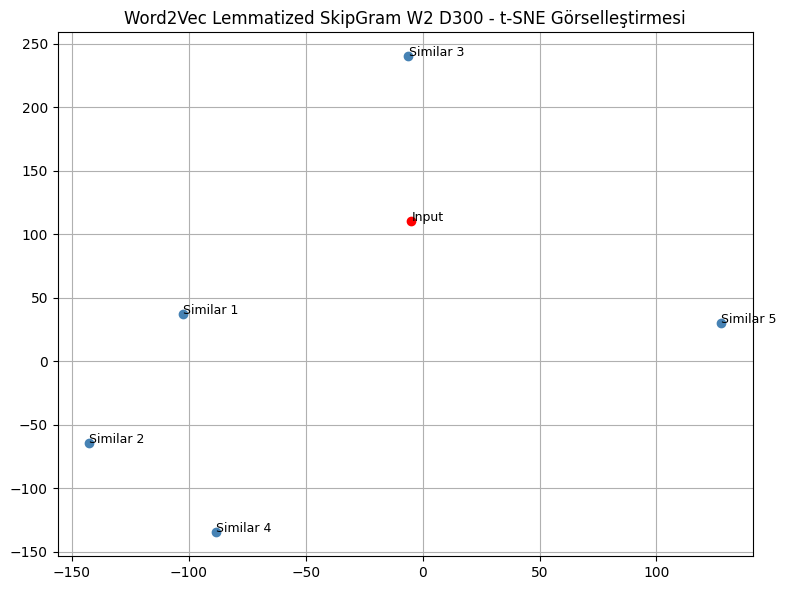


Word2Vec (Lemmatized SkipGram W2 D300) - En Benzer 5 Metin:
1. Satır No: 7205, Benzerlik Skoru: 0.9726
2. Satır No: 14609, Benzerlik Skoru: 0.9709
3. Satır No: 14911, Benzerlik Skoru: 0.9693
4. Satır No: 14771, Benzerlik Skoru: 0.9693
5. Satır No: 5515, Benzerlik Skoru: 0.9691


In [41]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordlemmatized.csv")
df["Tokens_Lemmatized"] = df["Tokens_Lemmatized"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Lemmatized"]

# 3. Word2Vec modelini yükle (SkipGram W2 D300)
model = Word2Vec.load("word2vec_lemmatized_skipgram_w2_d300.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Lemmatized"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["steelblue"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec Lemmatized SkipGram W2 D300 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Lemmatized SkipGram W2 D300) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_lemmatized_cbow_w4_d300.model" Modeli için hesaplama:**


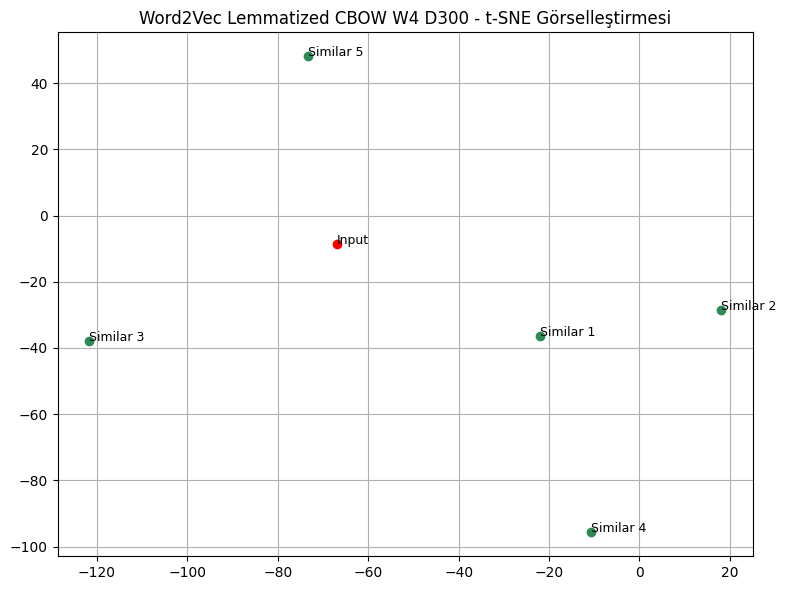


Word2Vec (Lemmatized CBOW W4 D300) - En Benzer 5 Metin:
1. Satır No: 14609, Benzerlik Skoru: 0.9171
2. Satır No: 14692, Benzerlik Skoru: 0.9157
3. Satır No: 19322, Benzerlik Skoru: 0.9135
4. Satır No: 14586, Benzerlik Skoru: 0.9126
5. Satır No: 3015, Benzerlik Skoru: 0.9117


In [42]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordlemmatized.csv")
df["Tokens_Lemmatized"] = df["Tokens_Lemmatized"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Lemmatized"]

# 3. Word2Vec modelini yükle (CBOW W4 D300)
model = Word2Vec.load("word2vec_lemmatized_cbow_w4_d300.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Lemmatized"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["seagreen"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec Lemmatized CBOW W4 D300 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Lemmatized CBOW W4 D300) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


**"word2vec_lemmatized_skipgram_w4_d300.model" Modeli için hesaplama:**


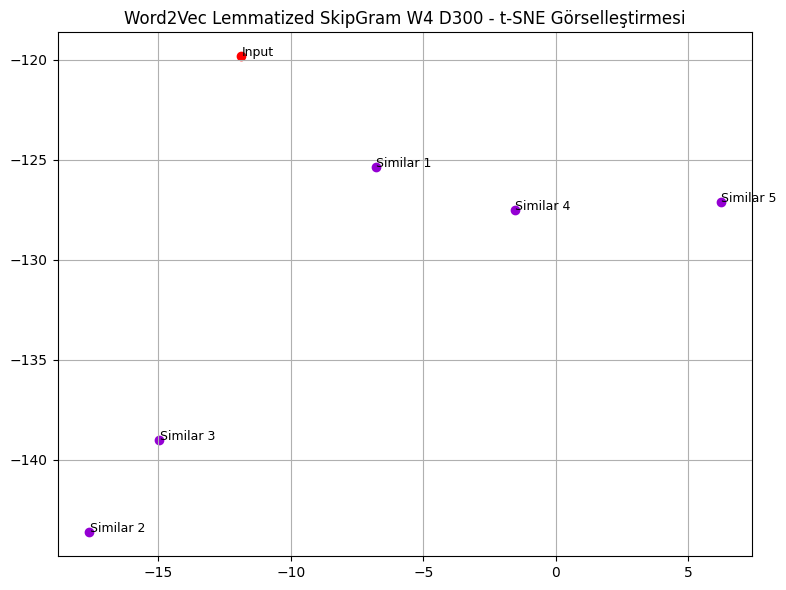


Word2Vec (Lemmatized SkipGram W4 D300) - En Benzer 5 Metin:
1. Satır No: 14609, Benzerlik Skoru: 0.9629
2. Satır No: 5758, Benzerlik Skoru: 0.9613
3. Satır No: 7205, Benzerlik Skoru: 0.9610
4. Satır No: 10501, Benzerlik Skoru: 0.9606
5. Satır No: 14911, Benzerlik Skoru: 0.9595


In [43]:
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Veri setini yükle
df = pd.read_csv("fordlemmatized.csv")
df["Tokens_Lemmatized"] = df["Tokens_Lemmatized"].astype(str).apply(ast.literal_eval)

# 2. Giriş metni (satır 6)
input_index = 6
input_tokens = df.loc[input_index, "Tokens_Lemmatized"]

# 3. Word2Vec modelini yükle (SkipGram W4 D300)
model = Word2Vec.load("word2vec_lemmatized_skipgram_w4_d300.model")

# 4. Ortalama vektörü hesaplama fonksiyonu
def get_avg_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 5. Giriş metni için ortalama vektör
input_vec = get_avg_vector(input_tokens, model).reshape(1, -1)

# 6. Tüm metinler için benzerlikleri hesapla
similarities = []
for idx, row in df.iterrows():
    if idx == input_index:
        continue
    avg_vec = get_avg_vector(row["Tokens_Lemmatized"], model).reshape(1, -1)
    sim = cosine_similarity(input_vec, avg_vec)[0][0]
    similarities.append((idx, sim, avg_vec))

# 7. En benzer 5 sonucu sırala
top5 = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

# 8. Giriş + top5 vektörlerini t-SNE için hazırla
selected_vectors = [input_vec[0]] + [item[2][0] for item in top5]
labels = ["Input"] + [f"Similar {i+1}" for i in range(5)]
colors = ["red"] + ["darkviolet"] * 5

# 9. t-SNE ile 2 boyuta indir
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_vectors = tsne.fit_transform(np.array(selected_vectors))

# 10. Görselleştir
plt.figure(figsize=(8, 6))
for i, vec in enumerate(reduced_vectors):
    plt.scatter(vec[0], vec[1], color=colors[i])
    plt.text(vec[0]+0.01, vec[1]+0.01, labels[i], fontsize=9)

plt.title("Word2Vec Lemmatized SkipGram W4 D300 - t-SNE Görselleştirmesi")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Benzerlik skorlarını yazdır
print("\nWord2Vec (Lemmatized SkipGram W4 D300) - En Benzer 5 Metin:")
for i, (idx, score, _) in enumerate(top5, 1):
    print(f"{i}. Satır No: {idx}, Benzerlik Skoru: {score:.4f}")


#**Word2Vec Jaccard Benzerlik Matrisi**

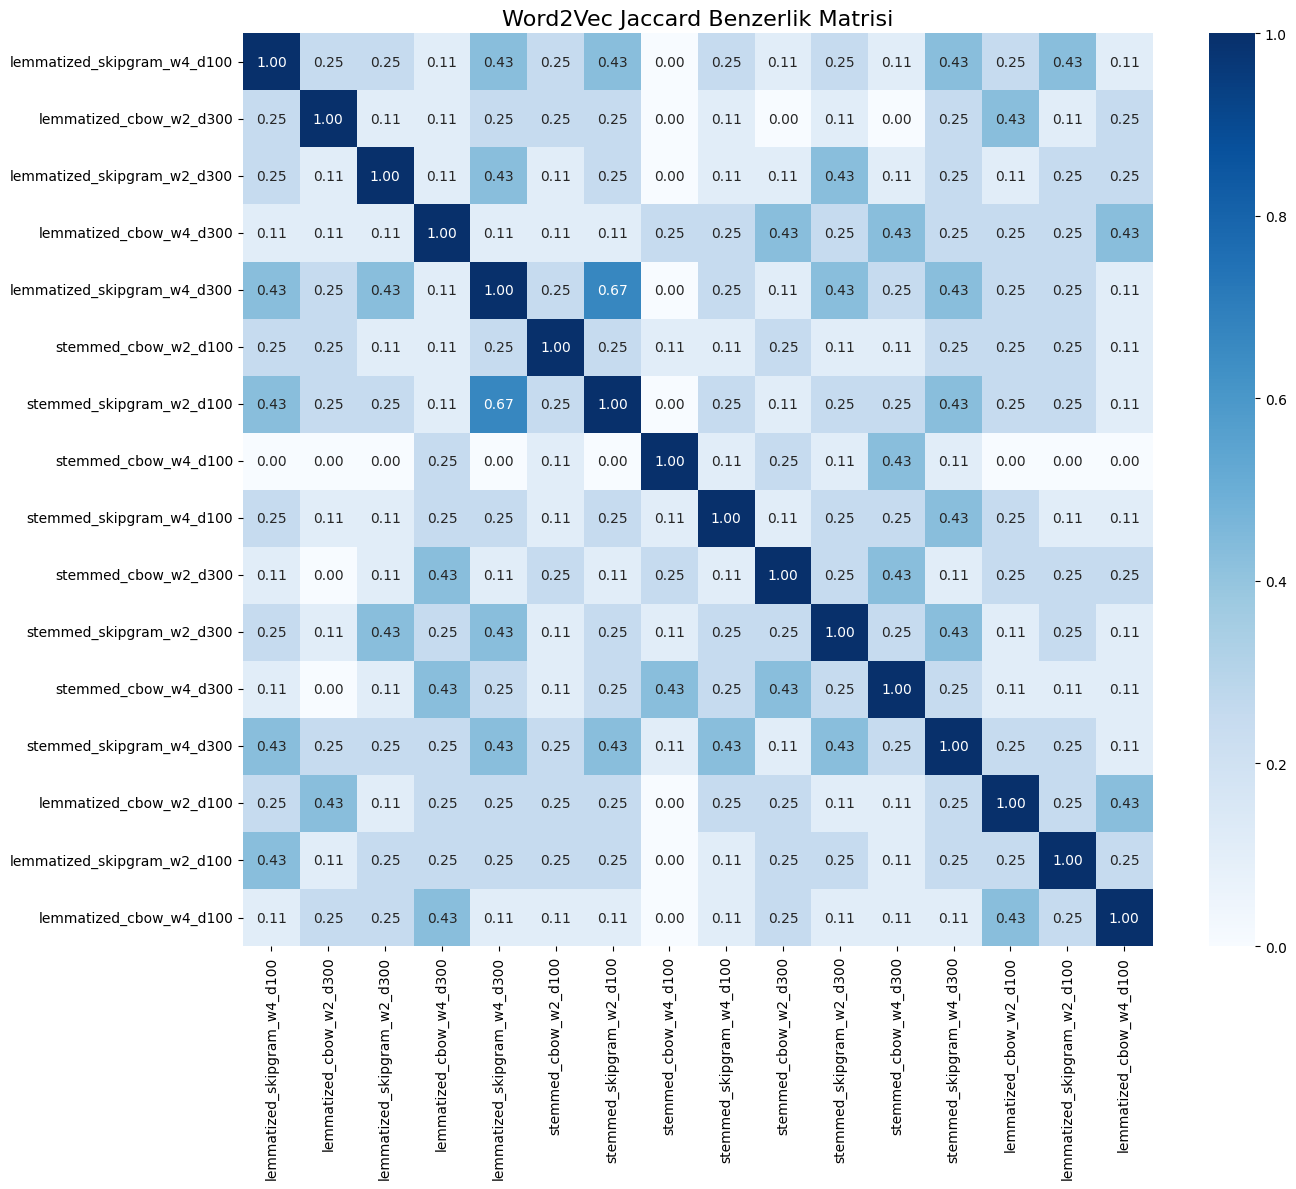

In [44]:
import pandas as pd

# Model isimleri ve satır listeleri (senin verdiğin ekran görüntülerinden çıkarılmıştır)
model_to_indices = {
    "lemmatized_skipgram_w4_d100": [14609, 7205, 5758, 1272, 10330],
    "lemmatized_cbow_w2_d300": [8800, 3015, 5758, 17008, 7205],
    "lemmatized_skipgram_w2_d300": [7205, 14609, 14911, 14771, 5515],
    "lemmatized_cbow_w4_d300": [14609, 14692, 19322, 14586, 3015],
    "lemmatized_skipgram_w4_d300": [14609, 5758, 7205, 10501, 14911],
    "stemmed_cbow_w2_d100": [5758, 7205, 15045, 19322, 9308],
    "stemmed_skipgram_w2_d100": [14609, 10501, 5855, 7205, 5758],
    "stemmed_cbow_w4_d100": [15045, 14586, 14692, 17332, 18451],
    "stemmed_skipgram_w4_d100": [14949, 5758, 14692, 4836, 14609],
    "stemmed_cbow_w2_d300": [15045, 19322, 14586, 13687, 14609],
    "stemmed_skipgram_w2_d300": [14609, 7205, 13687, 14911, 14692],
    "stemmed_cbow_w4_d300": [14692, 14609, 14586, 15045, 10501],
    "stemmed_skipgram_w4_d300": [14609, 5758, 7205, 2636, 14692],
    "lemmatized_cbow_w2_d100": [8800, 5758, 17008, 19322, 14609],
    "lemmatized_skipgram_w2_d100": [7205, 10330, 14609, 15148, 19322],
    "lemmatized_cbow_w4_d100": [3015, 14609, 19322, 14771, 17008],
}

# Jaccard hesaplama fonksiyonu
def jaccard_similarity(set1, set2):
    intersection = len(set(set1) & set(set2))
    union = len(set(set1) | set(set2))
    return intersection / union

# Matris oluştur
model_names = list(model_to_indices.keys())
jaccard_matrix = pd.DataFrame(index=model_names, columns=model_names, dtype=float)

for i in model_names:
    for j in model_names:
        jaccard_matrix.loc[i, j] = jaccard_similarity(model_to_indices[i], model_to_indices[j])

# Matris CSV olarak kaydet
jaccard_matrix.to_csv("jaccard_matrix.csv", index=True)

# Tabloyu göster
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 12))
sns.heatmap(jaccard_matrix.astype(float), annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Word2Vec Jaccard Benzerlik Matrisi", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#**En Yüksek Jaccard Benzerliğine Sahip Model Çiftleri**

In [45]:
import pandas as pd
from itertools import combinations

# Daha önce oluşturulan jaccard_matrix.csv dosyasını yükleyelim (ya da önceki DataFrame'i kullanabilirsin)
jaccard_matrix = pd.read_csv("jaccard_matrix.csv", index_col=0)

# En yüksek benzerlikli model çiftlerini bulalım (kendisiyle karşılaştırma hariç)
results = []

# Tüm benzersiz çiftleri sırayla kontrol et
for model1, model2 in combinations(jaccard_matrix.index, 2):
    score = jaccard_matrix.loc[model1, model2]
    results.append((model1, model2, score))

# Skora göre azalan şekilde sırala
sorted_results = sorted(results, key=lambda x: x[2], reverse=True)

# İlk 10 en yüksek skoru gösterelim
top_n = 10  # İstersen daha fazlasını alabilirsin
print(f"🔝 En Yüksek {top_n} Jaccard Benzerliğine Sahip Model Çiftleri:\n")
for i in range(top_n):
    m1, m2, score = sorted_results[i]
    print(f"{i+1}. {m1} ↔ {m2} → Jaccard Skoru: {score:.3f}")


🔝 En Yüksek 10 Jaccard Benzerliğine Sahip Model Çiftleri:

1. lemmatized_skipgram_w4_d300 ↔ stemmed_skipgram_w2_d100 → Jaccard Skoru: 0.667
2. lemmatized_skipgram_w4_d100 ↔ lemmatized_skipgram_w4_d300 → Jaccard Skoru: 0.429
3. lemmatized_skipgram_w4_d100 ↔ stemmed_skipgram_w2_d100 → Jaccard Skoru: 0.429
4. lemmatized_skipgram_w4_d100 ↔ stemmed_skipgram_w4_d300 → Jaccard Skoru: 0.429
5. lemmatized_skipgram_w4_d100 ↔ lemmatized_skipgram_w2_d100 → Jaccard Skoru: 0.429
6. lemmatized_cbow_w2_d300 ↔ lemmatized_cbow_w2_d100 → Jaccard Skoru: 0.429
7. lemmatized_skipgram_w2_d300 ↔ lemmatized_skipgram_w4_d300 → Jaccard Skoru: 0.429
8. lemmatized_skipgram_w2_d300 ↔ stemmed_skipgram_w2_d300 → Jaccard Skoru: 0.429
9. lemmatized_cbow_w4_d300 ↔ stemmed_cbow_w2_d300 → Jaccard Skoru: 0.429
10. lemmatized_cbow_w4_d300 ↔ stemmed_cbow_w4_d300 → Jaccard Skoru: 0.429


#**Word2Vec Anlamsal Değerlendirme Tablosu:**



In [46]:
# 1. Gerekli kütüphaneleri yükle
import pandas as pd

# 2. Google Colab'a dosya yükleme arayüzünü aç
from google.colab import files
uploaded = files.upload()

# 3. Yüklenen dosyanın adını girerek oku (örneğin: jaccard_matrix.csv)
df = pd.read_csv("Word2Vec_Anlamsal_De_erlendirme_Tablosu.csv")

# 4. Tabloyu göster
from IPython.display import display
display(df)


,Unnamed: 0,Model,Puanlar,Ortalama Puan
0,2,lemmatized_skipgram_w2_d300,"[5, 5, 4, 4, 3]",4.2
1,4,lemmatized_skipgram_w4_d300,"[5, 4, 4, 3, 4]",4.0
2,10,stemmed_skipgram_w2_d300,"[5, 4, 3, 4, 4]",4.0
3,14,lemmatized_skipgram_w2_d100,"[5, 4, 5, 3, 3]",4.0
4,0,lemmatized_skipgram_w4_d100,"[5, 4, 4, 2, 4]",3.8
5,6,stemmed_skipgram_w2_d100,"[5, 4, 2, 4, 4]",3.8
6,8,stemmed_skipgram_w4_d100,"[4, 4, 4, 3, 4]",3.8
7,12,stemmed_skipgram_w4_d300,"[5, 4, 4, 2, 4]",3.8
8,1,lemmatized_cbow_w2_d300,"[3, 3, 4, 3, 3]",3.2
9,13,lemmatized_cbow_w2_d100,"[3, 4, 3, 3, 3]",3.2
